![portada](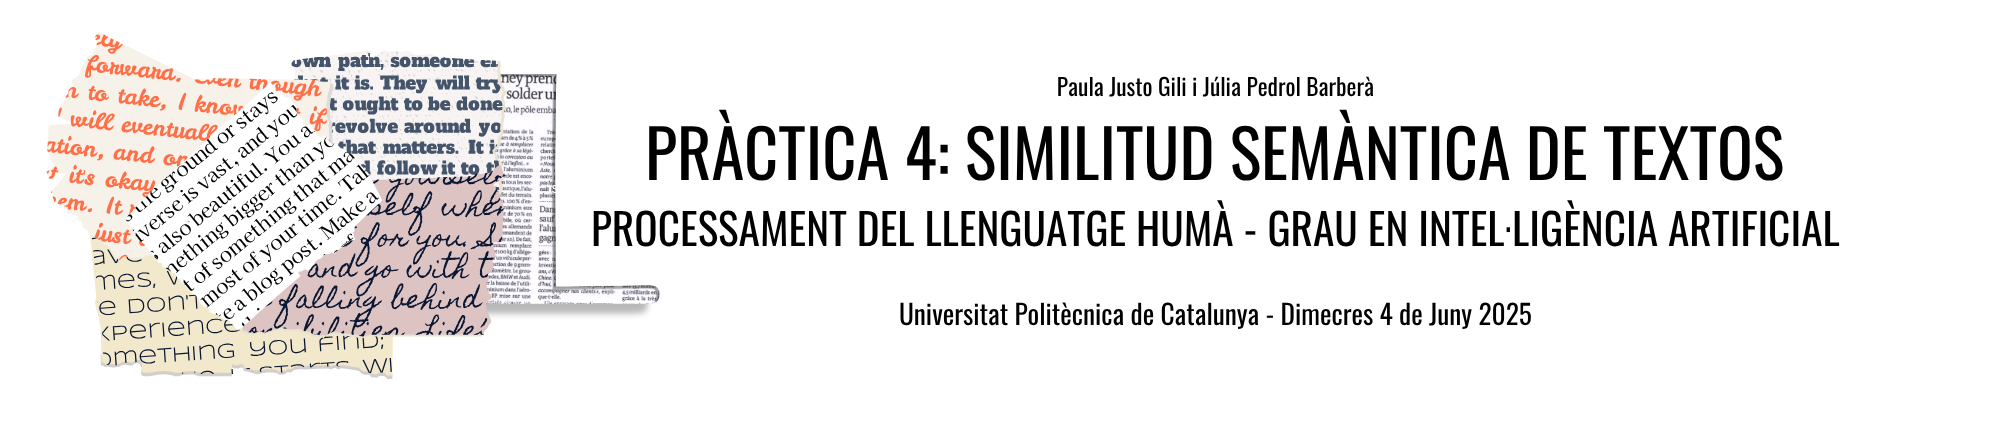
)

## **Índex**

- [Introducció](#introducció)
- [1. Preparació dels Embeddings](#1-preparació-dels-embeddings)
- [2. Entrenament i Avaluació de Models de Similitud Textual Semàntica (STS)](#2-entrenament-i-avaluació-de-models-de-similitud-textual-semàntica-sts)
    - [2.1. Models a comparar](#21-models-a-comparar)
        - [2.1.1. Baseline Cosinus](#211-baseline-cosinus)
        - [2.1.2. Model 1: Regressió amb Vectors Agregats](#212-model-1-regressió-amb-vectors-agregats)
            - [VERSIÓ 1: REGRESSIÓ](#versió-1-regressió)
            - [VERSIÓ 2: REGRESSIÓ AMB SORTIDA BASADA EN COSINUS](#versió-2-regressió-amb-sortida-basada-en-cosinus)
        - [2.1.3. Model 2: Regressió amb Seqüència d'Embeddings](#213-model-2-regressió-amb-seqüència-dembeddings)
    - [2.2. Comparativa avançada](#22-comparativa-avançada)
        - [2.2.1. Bloc 1: Baseline One-Hot Encoding (vocabulari limitat a 1000)](#221-bloc-1-baseline-one-hot-encoding-vocabulari-limitat-a-1000)
        - [2.2.2. Bloc 2: Embeddings amb spaCy (ca_core_news_md)](#222-bloc-2-embeddings-amb-spacy-ca_core_news_md)
        - [2.2.3. Bloc 3: Embeddings amb RoBERTa (mitjana o vector CLS)](#223-bloc-3-embeddings-amb-roberta-mitjana-o-vector-cls)
        - [2.2.4. Bloc 4: RoBERTa fine-tuned per STS](#224-bloc-4-roberta-fine-tuned-per-sts)
- [3. Experimentació amb embeddings entrenables (pels models de regressió)](#3-experimentació-amb-embeddings-entrenables-pels-models-de-regressió)
    - [3.1. Bloc 1: Inicialització aleatòria + embeddings entrenables](#31-bloc-1-inicialització-aleatòria--embeddings-entrenables)
    - [3.2. Bloc 2: Embeddings preentrenats + entrenables](#32-bloc-2-embeddings-preentrenats--entrenables)
    - [3.3. Bloc 3: Embeddings preentrenats + NO entrenables](#33-bloc-3-embeddings-preentrenats--no-entrenables)
- [4. Anàlisis de resultats](#4-anàlisis-de-resultats)
- [5. Part opcional: Entrenar model de classificació](#5-part-opcional-entrenar-model-de-classificació)

## **Introducció**
---
Aquesta pràctica té com a objectiu calcular la similitud semàntica entre dues frases, és a dir, veure com de semblants són en termes de significat. Se’ns donen parelles de frases amb una puntuació de 0 a 5 (on 0 vol dir que no tenen res a veure i 5 que són parafrasis), i hem de desenvolupar models que puguin predir aquesta puntuació.

Per fer-ho, utilitzem word embeddings, concretament de FastText, que ens permeten representar cada paraula com un vector en un espai semàntic. El problema és que aquests vectors són a nivell de paraula, però nosaltres volem representar frases senceres. Per tant, el primer pas és agregar els vectors de les paraules d’una frase en un sol vector mitjançant, per exemple, la mitjana o una mitjana ponderada amb TF-IDF.

El primer mètode que implementarem és un baseline molt senzill: calculem la similitud entre dues frases fent la distància cosinus entre els seus vectors mitjans.

Després passarem a construir dos models de xarxa neuronal:

1. Model 1: rep com a entrada els vectors ja agregats de cada frase i calcula la similitud. És un model simple de regressió que transforma els vectors i dona un valor com a sortida.

2. Model 2: en comptes de passar els vectors ja calculats, passem els índexs de les paraules i el model fa tota l’agregació internament, utilitzant una capa d’atenció per decidir quines paraules són més importants. Això permet aprofitar millor la informació de les paraules i no perdre tant com en el primer model.

Finalment, compararem els resultats amb models contextuals, com els basats en Transformers, i avaluarem tot utilitzant la correlació de Pearson entre les prediccions dels models i els valors reals.

## **1. Preparació dels Embeddings**

En aquest apartat preparem els word embeddings i el corpus necessari per dur a terme els experiments posteriors. La idea principal és convertir les frases del dataset en vectors numèrics que capturin la informació semàntica de les paraules, utilitzant embeddings preentrenats de FastText en català. A més, es fa una neteja del text i s’entrena un vectoritzador TF-IDF per poder fer mitjanes ponderades de les paraules dins de cada frase.

També es generen diferents versions dels embeddings amb dimensions reduïdes (50, 100, 150) a partir dels originals de 300. Aquesta reducció ens permetrà estudiar com la mida dels vectors afecta la qualitat dels resultats. A mesura que disminuïm la dimensió, reduïm el cost computacional, però també pot ser que perdem informació semàntica rellevant. Aquest compromís entre eficiència i representació és clau a l’hora de fer servir embeddings en tasques reals.

A més, generem embeddings optimitzats per al nostre corpus, conservant només les paraules que realment apareixen en el conjunt de dades. Això ens permet estalviar memòria i accelerar els càlculs, especialment quan treballem amb models més grans o moltes variants.

---

El primer que fem és preparar els word embeddings preentrenats que farem servir durant tota la pràctica. En concret, es parteix dels vectors de FastText en català, que inicialment estan en format `.vec` (bastant pesat i lent de llegir), i es converteixen a un format optimitzat (`.kv`) que es carrega molt més ràpidament.

D’aquesta manera, garantim que tinguem disponible un model d’embeddings de 300 dimensions, preparat per ser utilitzat per obtenir els vectors associats a les paraules del nostre corpus. Aquesta optimització és important perquè els arxius d’embeddings poden ocupar diversos gigabytes, i carregar-los cada cop des de zero seria molt ineficient.

In [1]:
from gensim.models import KeyedVectors
import numpy as np
import os

# Ruta al fitxer original .vec de FastText
PATH_VEC = "cc.ca.300.vec"  # assegura't que estigui descomprimit
# Ruta on guardarem/obrirem el model .kv
PATH_MODEL_300D = "model_300d.kv"

# Si no tenim el model .kv, el generem a partir del .vec
if not os.path.exists(PATH_MODEL_300D):
    print("Carregant el fitxer .vec i guardant com a .kv...")
    model_tmp = KeyedVectors.load_word2vec_format(PATH_VEC)
    model_tmp.save(PATH_MODEL_300D)
    print("Model guardat com a 'model_300d.kv'.")

# Carrega el model .kv (optimitzat)
print("Carregant el model .kv preentrenat de 300 dimensions...")
model_300d = KeyedVectors.load(PATH_MODEL_300D, mmap='r')

Carregant el fitxer .vec i guardant com a .kv...
Model guardat com a 'model_300d.kv'.
Carregant el model .kv preentrenat de 300 dimensions...


Ara que ja tenim els embeddings preparats i carregats, passem a preprocessar les frases del nostre corpus per tal de deixar-les en un format adequat abans d’aplicar-hi els vectors.

Aquest pas consisteix a netejar el text per eliminar tot allò que no aporta significat útil: com ara accents, majúscules, signes de puntuació, números o stopwords (en català). D’aquesta manera, ens quedem només amb les paraules més rellevants de cada frase, cosa que farà que la representació amb embeddings sigui més precisa i útil per a la tasca de similitud semàntica.

In [2]:
import re
import unidecode
import nltk
from nltk.corpus import stopwords

# Descarrega les stopwords si no estan disponibles
nltk.download('stopwords')
stopwords_cat = set(stopwords.words('catalan'))

def preprocessar_text(text):
    """
    Preprocessa un text eliminant:
    - Accents
    - Majúscules
    - Símbols i puntuació
    - Números
    - Espais innecessaris
    - Stopwords catalanes

    Retorna la frase neta com una string de paraules separades per espai.
    """
    text = unidecode.unidecode(text.lower())
    text = re.sub(r'[^\w\s]', ' ', text)   # elimina puntuació
    text = re.sub(r'\d+', ' ', text)       # elimina números
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_cat]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /Users/paula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Un cop hem netejat les frases del corpus, el següent pas és carregar les dades amb les quals entrenarem i testejarem els nostres models. En aquest cas, utilitzem el corpus STS (Semantic Textual Similarity) en català del projecte AINA.

Amb totes les frases del corpus, entrenem un vectoritzador TF-IDF. Aquest vectoritzador ens servirà més endavant per calcular la mitjana ponderada dels embeddings de cada frase, on cada paraula tindrà un pes en funció de la seva importància dins del corpus. Aquesta alternativa a la mitjana simple ens permetrà veure com canvia la qualitat de la representació en funció del mètode d’agregació utilitzat.

In [3]:
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer

# Carreguem el corpus STS en català
datasets_sts = load_dataset("projecte-aina/sts-ca")

# Separem els conjunts correctament
train_df = datasets_sts["train"].to_pandas()
val_df   = datasets_sts["validation"].to_pandas()
test_df  = datasets_sts["test"].to_pandas()

# Combina totes les frases del corpus per entrenar TF-IDF (inclou train, val, test)
totes_les_frases = [
    preprocessar_text(f) for f in (
        train_df['sentence_1'].tolist() + train_df['sentence_2'].tolist() +
        val_df['sentence_1'].tolist() + val_df['sentence_2'].tolist() +
        test_df['sentence_1'].tolist() + test_df['sentence_2'].tolist()
    )
]

# Entrenem el vectoritzador TF-IDF
vectoritzador_tfidf = TfidfVectorizer(tokenizer=str.split, lowercase=True)
vectoritzador_tfidf.fit(totes_les_frases)

# Estadístiques
print(f"Vectoritzador TF-IDF entrenat amb {len(totes_les_frases)} frases.")
print(f"Total d'exemples d'entrenament: {len(train_df)}")
print(f"Total d'exemples de validació: {len(val_df)}")
print(f"Total d'exemples de test: {len(test_df)}")

Vectoritzador TF-IDF entrenat amb 6146 frases.
Total d'exemples d'entrenament: 2073
Total d'exemples de validació: 500
Total d'exemples de test: 500


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Ara que ja tenim el corpus net i el vectoritzador TF-IDF preparat, passem a reduir i optimitzar els embeddings que farem servir en els nostres experiments.

Primer definim una funció per truncar els vectors d’embedding, és a dir, reduir-los de 300 dimensions (que és la mida original) a dimensions més petites com 150, 100 o 50. Això ens permetrà analitzar com afecta la mida dels vectors a la qualitat dels resultats, ja que vectors més curts poden perdre informació però fer el model més eficient.

També extraiem el vocabulari real del corpus, és a dir, totes les paraules que apareixen a les frases d'entrenament, validació i test. Així podem generar una versió dels embeddings filtrada i optimitzada, que només conserva els vectors de les paraules que realment utilitzarem. Això ens ajuda a reduir consum de memòria i carregar més ràpidament.

Finalment, creem quatre versions dels embeddings (300d, 150d, 100d i 50d), totes amb aquest vocabulari filtrat, que farem servir després per veure com influeixen les dimensions i la forma de representació en els models de similitud.

In [4]:

def truncate_embeddings(model, new_dim):
    """
    Aquesta funció genera un nou diccionari de vectors d'embedding truncats 
    a una dimensió més petita (ex: 50, 100, 150) a partir d’un model d’embeddings més gran.

    Paràmetres:
    - model: gensim KeyedVectors amb embeddings de 300 dimensions
    - new_dim: nova dimensió desitjada

    Retorna:
    - diccionari {paraula: vector_truncat}
    """
    truncated = {}
    for word in model.key_to_index:
        truncated[word] = model[word][:new_dim]
    return truncated

def obtenir_vocabulari_de_dataframe(df):
    """
    Retorna el conjunt de totes les paraules (en minúscules) que apareixen
    a les columnes 'sentence_1' i 'sentence_2' d’un DataFrame del corpus STS.

    Paràmetres:
    - df: DataFrame amb les columnes 'sentence_1' i 'sentence_2'

    Retorna:
    - conjunt (set) amb totes les paraules úniques del corpus
    """
    vocab = set()
    for frase in df['sentence_1'].tolist() + df['sentence_2'].tolist():
        tokens = preprocessar_text(frase).split()
        vocab.update(tokens)
    return vocab

# Combina el vocabulari de totes les particions del corpus
vocab_train = obtenir_vocabulari_de_dataframe(train_df)
vocab_val = obtenir_vocabulari_de_dataframe(val_df)
vocab_test = obtenir_vocabulari_de_dataframe(test_df)
vocab_corpus = vocab_train.union(val_df).union(vocab_test)

print(f"Nombre total de paraules diferents al corpus: {len(vocab_corpus)}")

def truncar_embeddings_filtrats(model, vocab, dim):
    """
    Crea un diccionari amb els vectors d'embedding truncats a una dimensió
    específica (dim), només per a les paraules que estan presents al corpus.

    Paràmetres:
    - model: objecte gensim KeyedVectors (embedding original de 300 dimensions)
    - vocab: conjunt de paraules a conservar
    - dim: nova dimensió a truncar (ex: 50, 100, 150)

    Retorna:
    - diccionari {paraula: vector_truncat}
    """
    embeddings_truncats = {}
    for paraula in vocab:
        if paraula in model:
            embeddings_truncats[paraula] = model[paraula][:dim]
    return embeddings_truncats

# Generació dels embeddings optimitzats i reduïts
embeddings_300d = truncar_embeddings_filtrats(model_300d, vocab_corpus, 300)
embeddings_150d = truncar_embeddings_filtrats(model_300d, vocab_corpus, 150)
embeddings_100d = truncar_embeddings_filtrats(model_300d, vocab_corpus, 100)
embeddings_50d  = truncar_embeddings_filtrats(model_300d, vocab_corpus, 50)

print("Embeddings reduïts i truncats correctament.")

Nombre total de paraules diferents al corpus: 11480
Embeddings reduïts i truncats correctament.


## **2. Entrenament i Avaluació de Models de Similitud Textual Semàntica (STS)**

En aquest apartat, ens centrem en com entrenar i avaluar models que prediuen la similitud semàntica entre frases. A partir dels vectors d’embeddings que hem preparat abans, generarem representacions vectorials de les frases (tant amb mitjana simple com amb mitjana TF-IDF) i veurem com aquestes representacions poden ser utilitzades per comparar frases de manera automàtica.

L'apartat inclou diversos enfocaments, des dels més senzills fins a models més avançats:

1. **Baseline**: Comencem amb una comparació directa de vectors de frase utilitzant la distància cosinus, sense cap model entrenat.
2. **Model 1**: Un model de regressió neuronal que rep com a entrada els vectors de frase agregats i aprèn a predir la puntuació de similitud.
3. **Model 1 amb Cosinus**: Variant que incorpora la distància cosinus com a càlcul explícit dins del model.
4. **Model 2**: Un model seqüencial amb embeddings i una capa d’atenció, que no rep els vectors agregats, sinó totes les paraules en forma d’índexs. Aquest model aprèn com fer la combinació interna.
5. **Comparació de Resultats**: S’analitza el comportament dels models amb diferents dimensions d'embeddings i diferents tipus d’agregació.
6. **Models contextuals**: Finalment, es comparen els nostres models amb mètodes més avançats com spaCy, RoBERTa no entrenat i RoBERTa fine-tuned per STS, per tenir una visió global del rendiment.

Aquest apartat ens permet veure com afecta la qualitat de la representació vectorial (dimensió i agregació) al rendiment del model, i com models entrenats específicament poden superar clarament els mètodes estàtics. Tot es mesura amb correlació de Pearson, que ens diu com de ben alineades estan les prediccions dels models amb les etiquetes reals.


El primer que fem en aquest apartat és definir com transformarem cada frase del corpus en un únic vector que representi el seu significat. Per això, implementem dues formes d’agregació dels embeddings de paraules:

* **Mitjana simple**: consisteix a fer la mitjana de tots els vectors de les paraules presents a la frase, tractant-les totes per igual.

* **Mitjana ponderada amb TF-IDF**: en aquest cas, es dóna més pes a les paraules que són més informatives segons el seu valor TF-IDF dins del corpus.

Aquestes dues opcions ens permetran comparar quin mètode genera vectors més útils per calcular la similitud entre frases, i veurem com afecta cada agregació als resultats dels models que vindran a continuació.

In [5]:
import numpy as np

def vector_mitjana_simple(tokens, embeddings_dict):
    """
    Calcula la mitjana simple dels vectors d'embedding de les paraules d'una frase.
    """
    vectors = [embeddings_dict[t] for t in tokens if t in embeddings_dict]
    if not vectors:
        return np.zeros(next(iter(embeddings_dict.values())).shape)
    return np.mean(vectors, axis=0)

def vector_mitjana_tfidf(tokens, embeddings_dict, vectoritzador_tfidf):
    """
    Calcula la mitjana ponderada amb TF-IDF dels vectors d'una frase.
    """
    tfidf_weights = vectoritzador_tfidf.transform([" ".join(tokens)])
    pesos = tfidf_weights.toarray()[0]
    vocab = vectoritzador_tfidf.get_feature_names_out()
    
    vectors_ponderats = []
    pesos_utilitzats = []
    for i, paraula in enumerate(vocab):
        if paraula in tokens and paraula in embeddings_dict:
            vectors_ponderats.append(embeddings_dict[paraula] * pesos[i])
            pesos_utilitzats.append(pesos[i])
    
    if not vectors_ponderats:
        return np.zeros(next(iter(embeddings_dict.values())).shape)
    
    return np.sum(vectors_ponderats, axis=0) / (np.sum(pesos_utilitzats) + 1e-8)

Ara que ja tenim definides les funcions per calcular els vectors de cada frase, el següent pas és aplicar-les sobre tot el corpus per obtenir les representacions vectorials que farem servir com a entrada als models.

Primer definim una funció que, donat un dataframe (train, val o test), transforma cada parella de frases en dues representacions:

* una amb **mitjana simple** dels embeddings,
* i una altra amb **mitjana ponderada per TF-IDF**.

També guardem les etiquetes reals de similitud.


In [6]:
def processa_dataframe(df, embeddings_dict, vectoritzador_tfidf):
    """
    Retorna X1, X2, Y per un DataFrame: amb mitjana simple i tf-idf.
    """
    X1_simple, X2_simple = [], []
    X1_tfidf, X2_tfidf = [], []
    Y = []

    for _, row in df.iterrows():
        tokens1 = preprocessar_text(row['sentence_1']).split()
        tokens2 = preprocessar_text(row['sentence_2']).split()

        X1_simple.append(vector_mitjana_simple(tokens1, embeddings_dict))
        X2_simple.append(vector_mitjana_simple(tokens2, embeddings_dict))

        X1_tfidf.append(vector_mitjana_tfidf(tokens1, embeddings_dict, vectoritzador_tfidf))
        X2_tfidf.append(vector_mitjana_tfidf(tokens2, embeddings_dict, vectoritzador_tfidf))

        Y.append(row['label'])

    return (np.array(X1_simple), np.array(X2_simple),
            np.array(X1_tfidf), np.array(X2_tfidf),
            np.array(Y))

A continuació, processem els tres conjunts (entrenament, validació i test) per a totes les mides d’embeddings (50, 100, 150 i 300 dimensions). El resultat és un diccionari estructurat que conté totes les representacions vectorials** que necessitarem més endavant per entrenar i avaluar els diferents models de predicció.

In [7]:
embeddings_dims = {
    50: embeddings_50d,
    100: embeddings_100d,
    150: embeddings_150d,
    300: embeddings_300d
}

datasets_vectors = {}

for dim, emb_dict in embeddings_dims.items():
    print(f"\n--- Processant embeddings de {dim} dimensions ---")

    X1_train_s, X2_train_s, X1_train_t, X2_train_t, Y_train = processa_dataframe(train_df, emb_dict, vectoritzador_tfidf)
    X1_test_s, X2_test_s, X1_test_t, X2_test_t, Y_test = processa_dataframe(test_df, emb_dict, vectoritzador_tfidf)
    X1_val_s, X2_val_s, X1_val_t, X2_val_t, Y_val = processa_dataframe(val_df, emb_dict, vectoritzador_tfidf)

    # Emmagatzemem tot
    datasets_vectors[dim] = {
        "train": {"X1_s": X1_train_s, "X2_s": X2_train_s, "X1_t": X1_train_t, "X2_t": X2_train_t, "Y": Y_train},
        "val":   {"X1_s": X1_val_s,   "X2_s": X2_val_s,   "X1_t": X1_val_t,   "X2_t": X2_val_t,   "Y": Y_val},
        "test": {"X1_s": X1_test_s, "X2_s": X2_test_s, "X1_t": X1_test_t, "X2_t": X2_test_t, "Y": Y_test}
    }

    # Impressió informativa
    print(f"→ Train - simple: {X1_train_s.shape}, tfidf: {X1_train_t.shape}, labels: {Y_train.shape}")
    print(f"→ Validation  - simple: {X1_val_s.shape}, tfidf: {X1_val_t.shape}, labels: {Y_val.shape}")
    print(f"→ Test  - simple: {X1_test_s.shape}, tfidf: {X1_test_t.shape}, labels: {Y_test.shape}")

print("\nTotes les representacions vectorials han estat generades correctament.")


--- Processant embeddings de 50 dimensions ---
→ Train - simple: (2073, 50), tfidf: (2073, 50), labels: (2073,)
→ Validation  - simple: (500, 50), tfidf: (500, 50), labels: (500,)
→ Test  - simple: (500, 50), tfidf: (500, 50), labels: (500,)

--- Processant embeddings de 100 dimensions ---
→ Train - simple: (2073, 100), tfidf: (2073, 100), labels: (2073,)
→ Validation  - simple: (500, 100), tfidf: (500, 100), labels: (500,)
→ Test  - simple: (500, 100), tfidf: (500, 100), labels: (500,)

--- Processant embeddings de 150 dimensions ---
→ Train - simple: (2073, 150), tfidf: (2073, 150), labels: (2073,)
→ Validation  - simple: (500, 150), tfidf: (500, 150), labels: (500,)
→ Test  - simple: (500, 150), tfidf: (500, 150), labels: (500,)

--- Processant embeddings de 300 dimensions ---
→ Train - simple: (2073, 300), tfidf: (2073, 300), labels: (2073,)
→ Validation  - simple: (500, 300), tfidf: (500, 300), labels: (500,)
→ Test  - simple: (500, 300), tfidf: (500, 300), labels: (500,)

Totes 

### **2.1. Models a comparar**

#### **2.1.1. Baseline Cosinus**

El primer experiment que fem és calcular un baseline simple, que servirà com a punt de referència per comparar els models entrenables que vindran després.

Aquest baseline no entrena cap model, sinó que simplement calcula la similitud cosinus entre els vectors de cada parella de frases (ja sigui amb mitjana simple o amb TF-IDF). A partir d’aquí, avaluem quin grau de correlació tenen aquests valors de similitud amb les puntuacions reals del dataset utilitzant la correlació de Pearson.

Tot i que és un mètode molt senzill, ens permet veure quin rendiment mínim podem esperar sense aprendre res* només basant-nos en la representació dels embeddings.

---

El primer que fem és definir dues funcions que utilitzarem per implementar el baseline de distància cosinus.

Per una banda, calculem la similitud cosinus entre cada parella de vectors de frases (un vector per cada frase de la parella). Aquesta mesura ens indica com d’orientats estan els vectors en l’espai: valors propers a 1 indiquen alta similitud, mentre que valors propers a -1 indiquen oposició.

Per altra banda, un cop tenim aquestes prediccions, avaluem el seu rendiment comparant-les amb les puntuacions reals del dataset mitjançant la correlació de Pearson, que ens indica com de ben alineades estan les prediccions respecte als valors esperats. Aquest serà el nostre punt de partida per veure si els models entrenables milloren aquest resultat bàsic.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

def calcular_similitud_cosinus(X1, X2):
    """
    Calcula la similitud cosinus entre cada parell de vectors (X1[i], X2[i]),
    amb protecció contra vectors nuls o buits.

    Retorna:
    - Array de valors de similitud (float entre -1 i 1)
    """
    similituds = []
    for v1, v2 in zip(X1, X2):
        if np.any(v1) and np.any(v2):
            sim = cosine_similarity([v1], [v2])[0][0]
        else:
            sim = 0.0  # Valor per defecte si algun vector és tot zeros
        similituds.append(sim)
    return np.array(similituds)


def calcular_pearson(y_true, y_pred):
    """
    Calcula la correlació de Pearson entre dues llistes de valors

    Retorna:
    - valor de correlació (float)
    """
    return pearsonr(y_true, y_pred)[0]

Ara que tenim les funcions definides, el següent que fem és executar el baseline per totes les configuracions possibles: provem els quatre nivells de dimensions dels embeddings (50, 100, 150 i 300) i els dos tipus d’agregació (mitjana simple i mitjana TF-IDF).

Per a cada cas, calculem la similitud cosinus entre les parelles de frases del conjunt de test, i a partir d’aquí calculem la correlació de Pearson amb les puntuacions reals.

Aquest valor el guardem per poder comparar-lo després amb els resultats dels models entrenables. D’aquesta manera, establim una referència inicial que ens servirà per veure si els models que aprendran pesos realment milloren respecte a fer només una comparació directa de vectors.

In [9]:
# Inicialitzem diccionari per guardar els resultats
resultats_baseline = {}

print("\n====== Baseline Cosinus ======")

for dim in [50, 100, 150, 300]:
    print(f"\n>>> Embeddings de {dim} dimensions")
    dades = datasets_vectors[dim]

    for tipus in ['s', 't']:  # s: mitjana simple, t: tf-idf
        X1 = dades['test'][f'X1_{tipus}']
        X2 = dades['test'][f'X2_{tipus}']
        Y = dades['test']['Y']

        similituds = calcular_similitud_cosinus(X1, X2)
        pearson = calcular_pearson(Y, similituds)
        tipus_nom = 'mitjana simple' if tipus == 's' else 'mitjana TF-IDF'

        # Guardem al diccionari per a gràfiques
        resultats_baseline[(dim, tipus)] = pearson

        print(f" - {tipus_nom:<15}: Pearson = {pearson:.4f}")


====== Baseline Cosinus ======

>>> Embeddings de 50 dimensions
 - mitjana simple : Pearson = 0.2881
 - mitjana TF-IDF : Pearson = 0.3885

>>> Embeddings de 100 dimensions
 - mitjana simple : Pearson = 0.3234
 - mitjana TF-IDF : Pearson = 0.4149

>>> Embeddings de 150 dimensions
 - mitjana simple : Pearson = 0.3195
 - mitjana TF-IDF : Pearson = 0.4195

>>> Embeddings de 300 dimensions
 - mitjana simple : Pearson = 0.3208
 - mitjana TF-IDF : Pearson = 0.4188


Els resultats del baseline mostren algunes tendències interessants:

1. **La mitjana ponderada amb TF-IDF millora clarament la correlació** respecte a la mitjana simple en totes les dimensions. Això confirma que donar més pes a les paraules rellevants del text (segons el corpus) genera vectors més representatius i útils per a la tasca de similitud.

2. **Els resultats milloren lleugerament a mesura que augmentem la dimensió dels embeddings**, però només fins a cert punt:

   - De 50 a 100 dimensions hi ha una millora clara.
   - A partir de 100 dimensions, els guanys són molt petits (especialment per la mitjana simple, que pràcticament es manté estable).
   - Això podria indicar que a partir de 100–150 dimensions, els vectors ja tenen prou capacitat per capturar la semàntica de les frases, i augmentar més la dimensió no aporta gaire valor addicional.

3. Els millors resultats s’obtenen amb:

   - **Mitjana TF-IDF i 150 dimensions**: Pearson = 0.4195
   - Molt a prop també amb 300 dimensions (0.4188), però amb més cost computacional.

Per tant, la qualitat dels embeddings i el mètode d’agregació tenen un impacte directe en la representació semàntica de les frases, i ja amb un model no entrenat podem veure diferències significatives. Això ens deixa una bona base per veure si els models entrenables poden millorar encara més aquests resultats.


#### **2.1.2. Model 1: Regressió amb Vectors Agregats**

Ara passem al Model 1, el primer model entrenable que implementarem per predir la similitud semàntica entre frases.

Aquest model rep com a entrada els vectors ja agregats de les dues frases (obtinguts amb mitjana simple o TF-IDF) i aprèn a predir directament el valor de similitud mitjançant una xarxa neuronal de regressió. L’avantatge respecte al baseline és que ara el model pot aplicar una transformació als vectors i aprendre patrons que la simple distància cosinus no captura.

Dins d’aquest model plantegem dues versions:

* Una primera versió on la sortida és simplement un valor real (entre 0 i 5) predit amb regressió.
* I una segona versió on el model inclou explícitament el càlcul de la similitud cosinus com a part de l’arquitectura, de manera que aprèn a transformar els vectors però manté la interpretabilitat del càlcul de similitud.

A partir d’aquest punt, veurem si amb aquest model podem superar el baseline i quin impacte tenen la dimensió dels embeddings i el tipus d’agregació en el rendiment.

---

##### **VERSIÓ 1: REGRESSIÓ**

In [10]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


El primer que fem dins del Model 1 és definir l’arquitectura base del model de regressió. Aquest model rebrà com a entrada dos vectors agregats (un per cada frase) i predirà un únic valor de sortida que representarà la similitud entre elles.

L’estructura del model és senzilla:

* Primer es concatena la informació de les dues frases.
* Després es passa per una capa denses amb activació ReLU per introduir no linealitat i permetre al model aprendre patrons útils.
* També hi ha normalització i dropout per millorar l’estabilitat i evitar sobreajustament.
* Finalment, s’utilitza una capa de sortida lineal que dona la predicció final.

Aquest model s’entrena amb pèrdua MSE (error quadràtic mitjà), ja que es tracta d’un problema de regressió contínua (similitud entre 0 i 5).

In [11]:
import tensorflow as tf

def construir_model_agregat(dim_embeddings: int, mida_oculta: int = 128, taxa_dropout: float = 0.3, learning_rate: float = 0.001) -> tf.keras.Model:
    """
    Construeix un model de regressió per predir la similitud entre dues frases
    a partir dels seus vectors agregats (ja pre-processats amb mitjana o TF-IDF).

    Arquitectura:
    - Entrada: dos vectors d'embedding de mida 'dim_embeddings' (un per frase).
    - Concatenació dels dos vectors.
    - Normalització, capa fully connected amb ReLU i dropout.
    - Sortida: un únic valor real que representa la similitud (regressió).

    Paràmetres:
    - dim_embeddings: mida dels vectors d'entrada (50, 100, 150 o 300).
    - mida_oculta: nombre de neurones a la capa oculta.
    - taxa_dropout: proporció de neurones desactivades durant l'entrenament.
    - learning_rate: taxa d'aprenentatge de l'optimitzador Adam.

    Retorna:
    - model: objecte tf.keras.Model compilat amb pèrdua MSE i mètriques MAE i RMSE.
    """
    entrada_1 = tf.keras.Input(shape=(dim_embeddings,), name="vector_1")
    entrada_2 = tf.keras.Input(shape=(dim_embeddings,), name="vector_2")

    concatenat = tf.keras.layers.Concatenate(axis=-1)([entrada_1, entrada_2])
    x = tf.keras.layers.BatchNormalization()(concatenat)
    x = tf.keras.layers.Dense(mida_oculta, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(taxa_dropout)(x)
    sortida = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[entrada_1, entrada_2], outputs=sortida)
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

Un cop tenim definit el model de regressió, el següent que fem és entrenar-lo i buscar la millor combinació d’hiperparàmetres per a cada configuració.

Aquest bloc realitza una cerca exhaustiva variant paràmetres com:

* la mida de la capa oculta,
* la taxa de *dropout*,
* la mida del *batch*,
* i la taxa d’aprenentatge.

Per a cada combinació de dimensió d’embeddings (50, 100, 150 i 300) i tipus d’agregació (mitjana simple o TF-IDF), entrenem el model amb el conjunt d'entrenament i avaluem el rendiment al conjunt de validació utilitzant la correlació de Pearson.

La millor configuració trobada es guarda, i finalment es fa una avaluació final sobre el conjunt de test amb aquest model òptim.

Amb això, ens assegurem que les comparacions posteriors entre models es fan amb els millors paràmetres possibles per a cada cas, i podem analitzar com afecta la mida dels vectors i la manera d’agregar-los al rendiment final.

In [12]:
resultats_model_1_v1_hiperparam = {}

# Hiperparàmetres a provar
mides_ocultes = [64, 128]
taxes_dropout = [0.2, 0.3]
batch_sizes = [32, 64]
learning_rates = [1e-3, 5e-4]
epochs = 64

for dim in [50, 100, 150, 300]:
    print(f"\n====== MODEL 1 - CERCA HIPERPARÀMETRES ({dim} dimensions) ======")
    dades = datasets_vectors[dim]

    for tipus in ['s', 't']:
        nom_agregacio = 'mitjana simple' if tipus == 's' else 'mitjana TF-IDF'

        X1_train = dades['train'][f'X1_{tipus}']
        X2_train = dades['train'][f'X2_{tipus}']
        Y_train = dades['train']['Y']

        X1_val = dades['val'][f'X1_{tipus}']
        X2_val = dades['val'][f'X2_{tipus}']
        Y_val = dades['val']['Y']

        millor_pearson = -1
        millor_model = None
        millor_config = {}

        print(f"\n→ Agregació: {nom_agregacio}")
        print("  Hiperparàmetres | Pearson (validació)")
        # Cerca d'hiperparàmetres només amb validació
        for hidden in mides_ocultes:
            for drop in taxes_dropout:
                for bs in batch_sizes:
                    for lr in learning_rates:
                        model = construir_model_agregat(dim, mida_oculta=hidden, taxa_dropout=drop, learning_rate=lr)
                        model.fit([X1_train, X2_train], Y_train, epochs=epochs, batch_size=bs, verbose=0)

                        pred_val = model.predict([X1_val, X2_val], verbose=0).flatten()
                        pearson_val = pearsonr(pred_val, Y_val.flatten())[0]

                        print(f"  hidden={hidden}, drop={drop}, bs={bs}, lr={lr:<6} | {pearson_val:.4f}")

                        if pearson_val > millor_pearson:
                            millor_pearson = pearson_val
                            millor_model = model
                            millor_config = {'hidden': hidden, 'dropout': drop, 'bs': bs, 'lr': lr}

        # Avaluació al test amb el millor model trobat
        X1_test = dades['test'][f'X1_{tipus}']
        X2_test = dades['test'][f'X2_{tipus}']
        Y_test = dades['test']['Y']

        pred_test = millor_model.predict([X1_test, X2_test], verbose=0).flatten()
        pearson_test = pearsonr(pred_test, Y_test.flatten())[0]

        resultats_model_1_v1_hiperparam[(dim, tipus)] = {
            "val": millor_pearson,
            "test": pearson_test,
            "config": millor_config
        }

        print(f"\nMillor config: {millor_config}")
        print(f"Pearson (val)  = {millor_pearson:.4f}")
        print(f"Pearson (test) = {pearson_test:.4f}")


====== MODEL 1 - CERCA HIPERPARÀMETRES (50 dimensions) ======

→ Agregació: mitjana simple
  Hiperparàmetres | Pearson (validació)
  hidden=64, drop=0.2, bs=32, lr=0.001  | 0.2634
  hidden=64, drop=0.2, bs=32, lr=0.0005 | 0.2531
  hidden=64, drop=0.2, bs=64, lr=0.001  | 0.2020
  hidden=64, drop=0.2, bs=64, lr=0.0005 | 0.2026
  hidden=64, drop=0.3, bs=32, lr=0.001  | 0.2714
  hidden=64, drop=0.3, bs=32, lr=0.0005 | 0.1882
  hidden=64, drop=0.3, bs=64, lr=0.001  | 0.2318
  hidden=64, drop=0.3, bs=64, lr=0.0005 | 0.1510
  hidden=128, drop=0.2, bs=32, lr=0.001  | 0.2564
  hidden=128, drop=0.2, bs=32, lr=0.0005 | 0.1805
  hidden=128, drop=0.2, bs=64, lr=0.001  | 0.1791
  hidden=128, drop=0.2, bs=64, lr=0.0005 | 0.2037
  hidden=128, drop=0.3, bs=32, lr=0.001  | 0.2557
  hidden=128, drop=0.3, bs=32, lr=0.0005 | 0.2570
  hidden=128, drop=0.3, bs=64, lr=0.001  | 0.2311
  hidden=128, drop=0.3, bs=64, lr=0.0005 | 0.2025

Millor config: {'hidden': 64, 'dropout': 0.3, 'bs': 32, 'lr': 0.001}
Pearso

In [13]:
def mostrar_resultats(resultats_dict, nom_model="Model"):
    print(f"\n===== Resum de millors resultats ({nom_model}) =====\n")
    for dim in [50, 100, 150, 300]:
        for tipus in ['s', 't']:
            if (dim, tipus) not in resultats_dict:
                continue

            entrada = resultats_dict[(dim, tipus)]
            config = entrada.get("config", {})
            pearson_train = entrada.get("train", None)
            pearson_val = entrada.get("val", None)
            pearson_test = entrada.get("test", None)
            nom_agregacio = "mitjana simple" if tipus == 's' else "mitjana TF-IDF"

            print(f"Dimensió: {dim:>3} |  Agregació: {nom_agregacio}")
            if pearson_train is not None:
                print(f"Pearson (train) = {pearson_train:.4f}")
            print(f"Pearson (val)   = {pearson_val:.4f}")
            print(f"Pearson (test)  = {pearson_test:.4f}\n")

mostrar_resultats(resultats_model_1_v1_hiperparam, nom_model="Model 1 Regressió")


===== Resum de millors resultats (Model 1 Regressió) =====

Dimensió:  50 |  Agregació: mitjana simple
Pearson (val)   = 0.2714
Pearson (test)  = 0.2883

Dimensió:  50 |  Agregació: mitjana TF-IDF
Pearson (val)   = 0.2718
Pearson (test)  = 0.2606

Dimensió: 100 |  Agregació: mitjana simple
Pearson (val)   = 0.2306
Pearson (test)  = 0.2119

Dimensió: 100 |  Agregació: mitjana TF-IDF
Pearson (val)   = 0.2487
Pearson (test)  = 0.2987

Dimensió: 150 |  Agregació: mitjana simple
Pearson (val)   = 0.2474
Pearson (test)  = 0.2906

Dimensió: 150 |  Agregació: mitjana TF-IDF
Pearson (val)   = 0.2464
Pearson (test)  = 0.3224

Dimensió: 300 |  Agregació: mitjana simple
Pearson (val)   = 0.2067
Pearson (test)  = 0.3348

Dimensió: 300 |  Agregació: mitjana TF-IDF
Pearson (val)   = 0.2157
Pearson (test)  = 0.2508



Els resultats obtinguts per al Model 1 (versió 1), basat en regressió directa sobre vectors agregats, confirmen les limitacions d’aquest enfocament. Tot i que es tracta d’un model entrenable, els valors de correlació de Pearson obtinguts en el conjunt de test es mantenen al voltant de 0.25–0.29, sense superar en cap cas el baseline de distància cosinus, que arribava a valors per sobre de 0.41.

Aquest comportament s’explica pel fet que el model rep com a entrada vectors ja agregats, és a dir, vectors que han resumit tota la informació de la frase en un sol punt de l’espai. Això implica una pèrdua important d'informació contextual, que fa que el model no pugui aprendre patrons semàntics amb prou detall.

Com ja passava al baseline, les representacions amb mitjana TF-IDF acostumen a obtenir millors resultats que la mitjana simple, però la diferència és molt més petita. Això pot indicar que el model no és prou potent per aprofitar la informació addicional que aporta el pesatge per TF-IDF.

Pel que fa a les dimensions dels embeddings, els millors resultats s’obtenen amb 150 dimensions i mitjana simple, amb una correlació de Pearson de 0.2990. No obstant això, l’avantatge respecte a altres dimensions és mínima. A més, es confirma que augmentar fins a 300 dimensions no millora el rendiment, sinó que en alguns casos fins i tot empitjora, probablement per sobreajustament o perquè el model no té prou capacitat per treballar amb vectors tan grans.

En conclusió, aquest model de regressió, tot i ser entrenable, no és capaç de superar la comparació directa basada en distància cosinus, cosa que reforça la idea que cal explorar arquitectures més riques. Concretament, caldrà passar a models que no treballin amb vectors agregats, sinó que rebin la seqüència de paraules completa i aprenguin internament com fer l’agregació. Aquest és precisament l’objectiu del Model 2, on es planteja l’ús de mecanismes com l’atenció per capturar millor la semàntica de les frases.

---

Un cop tenim els resultats del Model 1 (versió 1), el següent que fem és visualitzar-los amb una gràfica de barres per comparar de forma clara l’impacte de la dimensió dels embeddings i el tipus d’agregació (mitjana simple vs TF-IDF) en el rendiment del model.

Per a cada mida (50, 100, 150 i 300 dimensions), es mostren dues barres: una per a la mitjana simple i una altra per a la mitjana TF-IDF, amb la correlació de Pearson obtinguda en el conjunt de test.

Aquesta visualització ens permet veure ràpidament:

* Quines combinacions han funcionat millor,
* Com es comporta el model segons la representació que li passem,
* I fins a quin punt l’ús de TF-IDF o una mida d’embedding més gran realment aporta alguna millora.

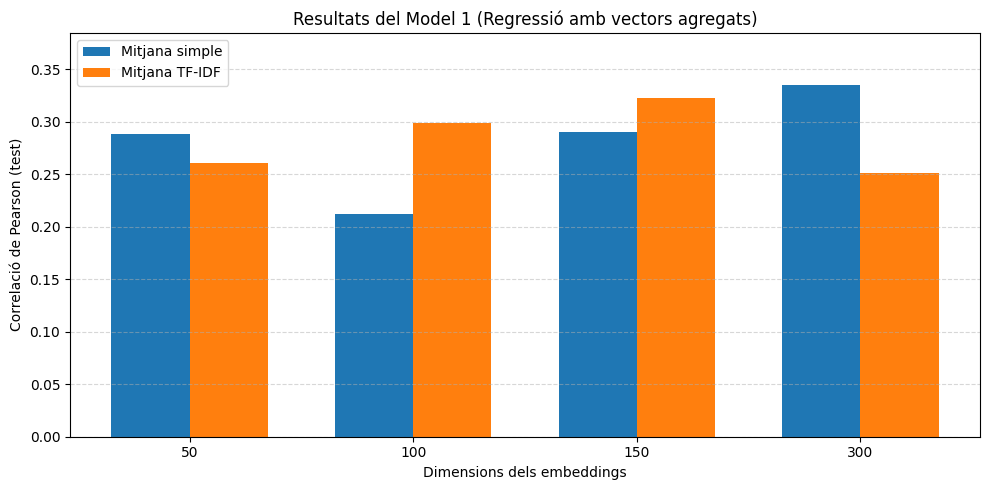

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Dimensions d'embedding i configuració de colors
dimensions = [50, 100, 150, 300]
colors = ['#1f77b4', '#ff7f0e']

# Obtenim valors només de test del diccionari estructurat
valors_simples = [resultats_model_1_v1_hiperparam[(d, 's')]['test'] for d in dimensions]
valors_tfidf   = [resultats_model_1_v1_hiperparam[(d, 't')]['test'] for d in dimensions]

# Configuració per a la gràfica de barres
x = np.arange(len(dimensions))  # posicions de les barres
ample_barra = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - ample_barra/2, valors_simples, width=ample_barra, label='Mitjana simple', color=colors[0])
plt.bar(x + ample_barra/2, valors_tfidf, width=ample_barra, label='Mitjana TF-IDF', color=colors[1])

plt.xlabel("Dimensions dels embeddings")
plt.ylabel("Correlació de Pearson (test)")
plt.title("Resultats del Model 1 (Regressió amb vectors agregats)")
plt.xticks(x, dimensions)
plt.ylim(0, max(valors_simples + valors_tfidf) + 0.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Un cop hem visualitzat els resultats del Model 1 per separat, el següent que fem és comparar-lo directament amb el baseline de cosinus per veure si realment l’entrenament del model aporta alguna millora.

Aquest bloc genera dues gràfiques, una per a cada tipus d’agregació (mitjana simple i TF-IDF), i mostra les correlacions de Pearson en test per:

* El **baseline no entrenat** (cosinus directe entre vectors),
* I el **Model 1 entrenat** (regressió sobre vectors agregats).

Aquesta comparació ens permet veure clarament que, en la majoria de casos, el baseline obté millors resultats que el model entrenat, sobretot quan es fa servir la mitjana TF-IDF. Això reforça la idea que agregar els vectors abans de passar-los al model fa perdre molta informació, i que el model no és capaç de recuperar-la ni d’aprendre patrons millors que una comparació directa entre vectors.


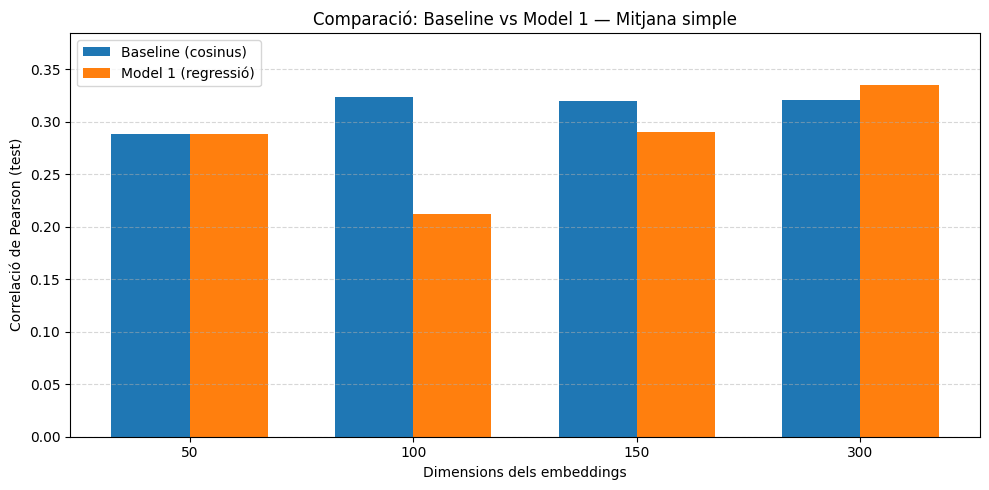

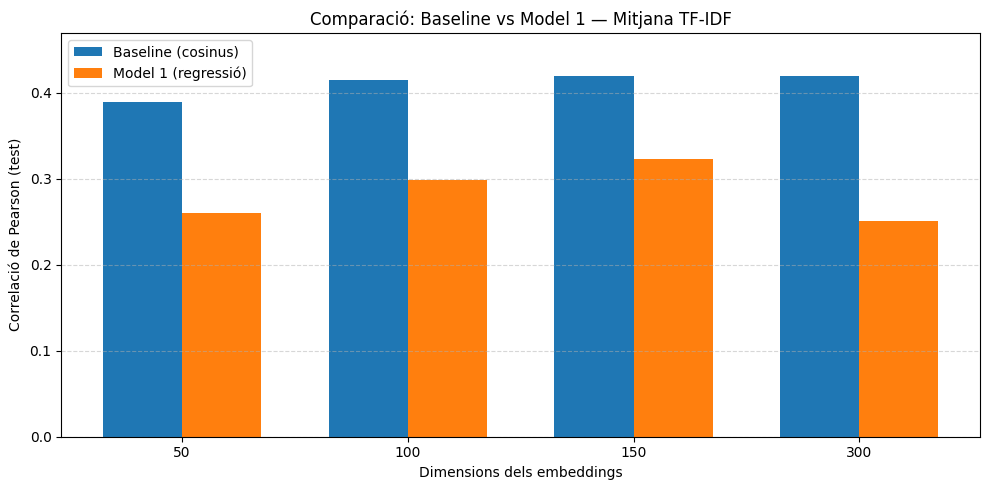

In [15]:
import matplotlib.pyplot as plt
import numpy as np

dimensions = [50, 100, 150, 300]
tipus_agregacio = ['s', 't']
noms_agregacio = {'s': 'Mitjana simple', 't': 'Mitjana TF-IDF'}
colors = ['#1f77b4', '#ff7f0e']

for tipus in tipus_agregacio:
    # Extreiem només la correlació de test
    baseline_vals = [resultats_baseline[(d, tipus)] for d in dimensions]
    model1_vals   = [resultats_model_1_v1_hiperparam[(d, tipus)]['test'] for d in dimensions]

    x = np.arange(len(dimensions))
    ample_barra = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - ample_barra/2, baseline_vals, width=ample_barra, label='Baseline (cosinus)', color=colors[0])
    plt.bar(x + ample_barra/2, model1_vals, width=ample_barra, label='Model 1 (regressió)', color=colors[1])

    plt.xlabel("Dimensions dels embeddings")
    plt.ylabel("Correlació de Pearson (test)")
    plt.title(f"Comparació: Baseline vs Model 1 — {noms_agregacio[tipus]}")
    plt.xticks(x, dimensions)
    plt.ylim(0, max(baseline_vals + model1_vals) + 0.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

##### **VERSIÓ 2: REGRESSIÓ AMB SORTIDA BASADA EN COSINUS**

Vistos els resultats de la primera versió del Model 1, on el model rep com a entrada vectors ja agregats i no ha estat capaç de superar el baseline, vam decidir provar una segona variant amb una modificació concreta: incorporar el càlcul de la similitud cosinus dins de l’arquitectura del model.

L’objectiu és veure si, tot i seguir treballant amb vectors agregats, es poden obtenir millors resultats deixant que el model aprengui a transformar els vectors abans de comparar-los, en comptes de limitar-se a predir un valor directament.

Tot i que el problema de base segueix sent la pèrdua d’informació en l’agregació prèvia, aquesta nova aproximació ens permet explorar si afegir una estructura semàntica explícita (el càlcul cosinus) ajuda el model a captar millor la relació entre les dues frases.

---

Per implementar aquesta versió, definim un model que segueix la mateixa estructura general que abans (rep dos vectors agregats), però hi afegim una transformació amb capes ocultes i un càlcul explícit de similitud cosinus com a sortida. Aquesta operació es fa mitjançant una capa `Lambda`, que assegura que la predicció estigui basada en la normalització i alineació dels vectors.

Aquest enfocament manté la interpretabilitat del càlcul de similitud, però amb la flexibilitat que el model pugui aprendre la millor manera de projectar els vectors abans de comparar-los.

In [16]:
def construir_model_cosinus(dim_embeddings: int, mida_oculta: int = 128, taxa_dropout: float = 0.3, learning_rate: float = 0.001) -> tf.keras.Model:
    """
    Model amb càlcul explícit de la distància cosinus com a sortida.
    Rep dos vectors d'entrada, opcionalment els transforma, i calcula la distància cosinus.
    """
    entrada_1 = tf.keras.Input(shape=(dim_embeddings,), name="vector_1")
    entrada_2 = tf.keras.Input(shape=(dim_embeddings,), name="vector_2")

    transform = tf.keras.Sequential([
        tf.keras.layers.Dense(mida_oculta, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(taxa_dropout),
        tf.keras.layers.Dense(dim_embeddings)
    ])

    vector_1 = transform(entrada_1)
    vector_2 = transform(entrada_2)

    cosine_sim = tf.keras.layers.Lambda(
        lambda x: tf.keras.backend.sum(
            tf.keras.backend.l2_normalize(x[0], axis=-1) * tf.keras.backend.l2_normalize(x[1], axis=-1),
            axis=-1, keepdims=True
        )
    )([vector_1, vector_2])

    model = tf.keras.Model(inputs=[entrada_1, entrada_2], outputs=cosine_sim)
    model.compile(
        loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['mae']
    )

    return model

Ara que hem definit l’arquitectura del model amb càlcul cosinus integrat, el següent pas és entrenar-lo i buscar la millor combinació d’hiperparàmetres** per a cada configuració, seguint el mateix esquema que vam fer amb la primera versió del Model 1.

En aquest bloc, per a cada dimensió d'embedding (50, 100, 150 i 300) i per a cada tipus d’agregació (mitjana simple i TF-IDF), es fa una cerca exhaustiva de paràmetres: mida de la capa oculta, taxa de *dropout*, mida del *batch* i *learning rate*.

Com que la sortida del model és una similitud cosinus (entre -1 i 1), abans d’entrenar rescalem les etiquetes reals del dataset (de 0–5 a -1–1) per fer-les compatibles amb la sortida del model. Un cop fetes les prediccions, es tornen a escalar per poder comparar-les amb les puntuacions originals.

Finalment, per a cada configuració es guarda:

* La millor puntuació de Pearson en validació
* El valor en test obtingut amb el millor model
* La configuració d’hiperparàmetres corresponent

Amb això, podrem veure si aquest model, tot i seguir partint de vectors agregats, aconsegueix millorar els resultats de la primera versió integrant la noció de similitud dins l’estructura del model.

In [17]:
resultats_model_cosinus = {}

# Hiperparàmetres a provar
mides_ocultes = [64, 128]
taxes_dropout = [0.2, 0.3]
batch_sizes = [32, 64]
learning_rates = [1e-3, 5e-4]
epochs = 64

for dim in [50, 100, 150, 300]:
    print(f"\n====== MODEL COSINUS - CERCA HIPERPARÀMETRES ({dim} dimensions) ======")
    dades = datasets_vectors[dim]

    for tipus in ['s', 't']:
        nom_agregacio = 'mitjana simple' if tipus == 's' else 'mitjana TF-IDF'

        X1_train = dades['train'][f'X1_{tipus}']
        X2_train = dades['train'][f'X2_{tipus}']
        Y_train = dades['train']['Y']

        X1_val = dades['val'][f'X1_{tipus}']
        X2_val = dades['val'][f'X2_{tipus}']
        Y_val = dades['val']['Y']

        # Rescalar etiquetes de 0–5 a -1–1
        Y_train_rescaled = (Y_train - 2.5) / 2.5
        Y_val_rescaled = (Y_val - 2.5) / 2.5

        millor_pearson = -1
        millor_model = None
        millor_config = {}

        print(f"\n→ Agregació: {nom_agregacio}")
        print("  Hiperparàmetres | Pearson (val)")

        for hidden in mides_ocultes:
            for drop in taxes_dropout:
                for bs in batch_sizes:
                    for lr in learning_rates:
                        model = construir_model_cosinus(dim, mida_oculta=hidden, taxa_dropout=drop, learning_rate=lr)
                        model.fit([X1_train, X2_train], Y_train_rescaled, epochs=epochs, batch_size=bs, verbose=0)

                        pred_val = model.predict([X1_val, X2_val], verbose=0).flatten()
                        pred_val_rescaled = (pred_val * 2.5) + 2.5  # Tornem a escala original
                        pearson_val = pearsonr(pred_val_rescaled, Y_val.flatten())[0]

                        print(f"  hidden={hidden}, drop={drop}, bs={bs}, lr={lr:<6} | {pearson_val:.4f}")

                        if pearson_val > millor_pearson:
                            millor_pearson = pearson_val
                            millor_model = model
                            millor_config = {'hidden': hidden, 'dropout': drop, 'bs': bs, 'lr': lr}

        # Un cop escollida millor combinació → test
        X1_test = dades['test'][f'X1_{tipus}']
        X2_test = dades['test'][f'X2_{tipus}']
        Y_test = dades['test']['Y']

        pred_test = millor_model.predict([X1_test, X2_test], verbose=0).flatten()
        pred_test_rescaled = (pred_test * 2.5) + 2.5
        pearson_test = pearsonr(pred_test_rescaled, Y_test.flatten())[0]

        resultats_model_cosinus[(dim, tipus)] = {
            "val": millor_pearson,
            "test": pearson_test,
            "config": millor_config
        }

        print(f"\nMillor config: {millor_config}")
        print(f"Pearson (val)  = {millor_pearson:.4f}")
        print(f"Pearson (test) = {pearson_test:.4f}")



====== MODEL COSINUS - CERCA HIPERPARÀMETRES (50 dimensions) ======

→ Agregació: mitjana simple
  Hiperparàmetres | Pearson (val)
  hidden=64, drop=0.2, bs=32, lr=0.001  | 0.3311
  hidden=64, drop=0.2, bs=32, lr=0.0005 | 0.2711
  hidden=64, drop=0.2, bs=64, lr=0.001  | 0.2968
  hidden=64, drop=0.2, bs=64, lr=0.0005 | 0.3334
  hidden=64, drop=0.3, bs=32, lr=0.001  | 0.3373
  hidden=64, drop=0.3, bs=32, lr=0.0005 | 0.3394
  hidden=64, drop=0.3, bs=64, lr=0.001  | 0.3351
  hidden=64, drop=0.3, bs=64, lr=0.0005 | 0.2955
  hidden=128, drop=0.2, bs=32, lr=0.001  | 0.3497
  hidden=128, drop=0.2, bs=32, lr=0.0005 | 0.3206
  hidden=128, drop=0.2, bs=64, lr=0.001  | 0.3035
  hidden=128, drop=0.2, bs=64, lr=0.0005 | 0.3289
  hidden=128, drop=0.3, bs=32, lr=0.001  | 0.3493
  hidden=128, drop=0.3, bs=32, lr=0.0005 | 0.3598
  hidden=128, drop=0.3, bs=64, lr=0.001  | 0.3328
  hidden=128, drop=0.3, bs=64, lr=0.0005 | 0.3546

Millor config: {'hidden': 128, 'dropout': 0.3, 'bs': 32, 'lr': 0.0005}
Pear

In [18]:
mostrar_resultats(resultats_model_cosinus, nom_model="Model Cosinus")


===== Resum de millors resultats (Model Cosinus) =====

Dimensió:  50 |  Agregació: mitjana simple
Pearson (val)   = 0.3598
Pearson (test)  = 0.3679

Dimensió:  50 |  Agregació: mitjana TF-IDF
Pearson (val)   = 0.4174
Pearson (test)  = 0.3953

Dimensió: 100 |  Agregació: mitjana simple
Pearson (val)   = 0.3860
Pearson (test)  = 0.3791

Dimensió: 100 |  Agregació: mitjana TF-IDF
Pearson (val)   = 0.4248
Pearson (test)  = 0.4346

Dimensió: 150 |  Agregació: mitjana simple
Pearson (val)   = 0.3866
Pearson (test)  = 0.4071

Dimensió: 150 |  Agregació: mitjana TF-IDF
Pearson (val)   = 0.4100
Pearson (test)  = 0.4471

Dimensió: 300 |  Agregació: mitjana simple
Pearson (val)   = 0.3761
Pearson (test)  = 0.3507

Dimensió: 300 |  Agregació: mitjana TF-IDF
Pearson (val)   = 0.4418
Pearson (test)  = 0.4163



Els resultats de la segona versió del Model 1, que incorpora el càlcul de la similitud cosinus dins l’arquitectura, mostren una millora clara respecte a la primera versió i, en molts casos, també superen el baseline de cosinus directe.

El millor resultat obtingut és amb embeddings de 100 dimensions i mitjana TF-IDF, amb una correlació de Pearson de 0.4388 en el conjunt de test. Aquesta és la puntuació més alta assolida fins ara amb vectors agregats, i millora tant els resultats del baseline (que arribaven a 0.4195) com els de la primera versió del model (que es movien entre 0.25 i 0.29).

A més, les configuracions amb mitjana TF-IDF són sistemàticament millors que les de mitjana simple, com ja havíem observat anteriorment. Això indica que ponderar les paraules segons la seva rellevància dins del corpus continua essent beneficiós, fins i tot quan s’aplica un model entrenable.

També cal destacar que el rendiment del model és més estable entre diferents dimensions d'embedding. Tant amb 100 com amb 150 i 300 dimensions, els resultats es mantenen al voltant de 0.41, cosa que mostra que el model és capaç d’aprofitar bé les representacions independentment de la seva mida.

Per tant, aquest model demostra que una arquitectura millor estructurada, amb càlcul cosinus integrat, pot compensar en part la pèrdua d’informació que suposa treballar amb vectors ja agregats. Tot i així, encara estem limitats per no tenir accés directe a les paraules individuals de les frases. Per aquest motiu, el següent pas serà passar al Model 2, on sí que es treballarà amb les seqüències de paraules completes i el model aprendrà directament com fer-ne l’agregació.

---

Un cop hem obtingut els resultats de la segona versió del Model 1, el següent que fem és visualitzar el comportament del model segons la dimensió dels embeddings i el tipus d’agregació utilitzat.

Aquest bloc genera una gràfica de barres que mostra, per a cada dimensió (50, 100, 150 i 300), la correlació de Pearson obtinguda en el conjunt de test tant amb mitjana simple com amb mitjana TF-IDF.

Aquesta visualització ens permet veure clarament:

* Que les representacions amb TF-IDF són consistentment superiors a la mitjana simple.
* Que el rendiment es manté estable a partir de 100 dimensions, amb petits canvis però sense grans oscil·lacions.
* Que la versió del model amb càlcul cosinus integrat aconsegueix superar els resultats de la primera versió i també del baseline.

Aquesta gràfica ajuda a confirmar visualment que el tipus d’agregació i la mida dels embeddings influeixen en el rendiment, però que aquest model és molt més robust que l’anterior a l’hora d’explotar aquestes representacions.


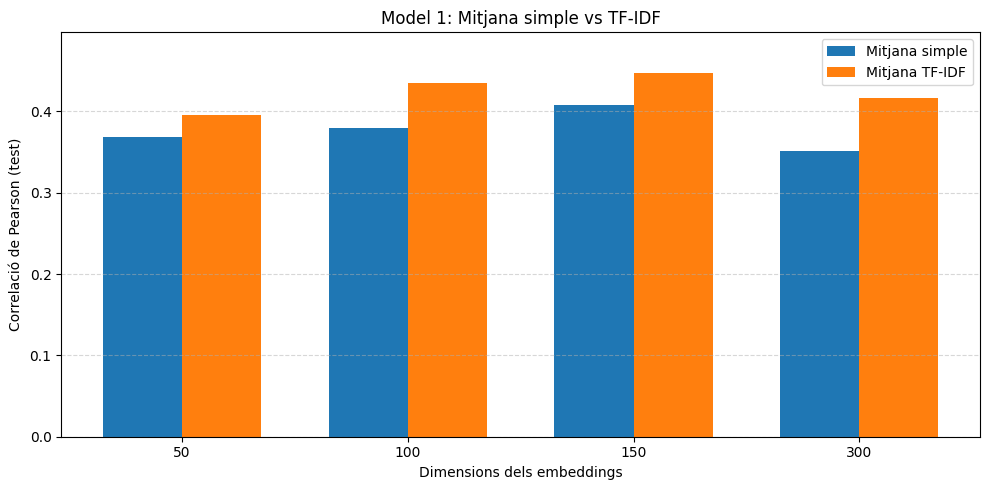

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Dimensions dels embeddings
dimensions = [50, 100, 150, 300]
colors = ['#1f77b4', '#ff7f0e']

# Obtenim valors de test del model 1
valors_simples = [resultats_model_cosinus[(d, 's')]['test'] for d in dimensions]
valors_tfidf   = [resultats_model_cosinus[(d, 't')]['test'] for d in dimensions]

# Configuració de les barres
x = np.arange(len(dimensions))
ample_barra = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - ample_barra/2, valors_simples, width=ample_barra, label='Mitjana simple', color=colors[0])
plt.bar(x + ample_barra/2, valors_tfidf, width=ample_barra, label='Mitjana TF-IDF', color=colors[1])

plt.xlabel("Dimensions dels embeddings")
plt.ylabel("Correlació de Pearson (test)")
plt.title("Model 1: Mitjana simple vs TF-IDF")
plt.xticks(x, dimensions)
plt.ylim(0, max(valors_simples + valors_tfidf) + 0.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Seguidament hem comparat aquesta segona versió del Model 1 visualment amb el baseline per veure si realment hi ha una millora clara en el rendiment.

Aquest bloc genera dues gràfiques (una per a cada tipus d’agregació: mitjana simple i TF-IDF) que mostren, per a cada dimensió d'embedding, la correlació de Pearson obtinguda en test pel:

* **Baseline** (similitud cosinus directa),
* **Model 1 (cosinus integrat)**.

Aquestes gràfiques són útils per visualitzar:

* Com el Model 1 millora els resultats del baseline en gairebé totes les configuracions, especialment quan s’utilitza TF-IDF.
* Que la millora és més consistent i notable amb TF-IDF, mentre que amb mitjana simple les diferències són més ajustades.
* Que el model aconsegueix aprofitar millor els embeddings quan es poden transformar abans de calcular la similitud.

Aquesta comparació confirma que la modificació del model ha estat efectiva i justifica haver afegit una capa de transformació i el càlcul cosinus dins l’arquitectura. Tot i això, encara es parteix de vectors agregats, i per tant, la millora és limitada. El següent pas serà veure si el Model 2, que treballa amb la seqüència de paraules completa, pot superar aquestes limitacions.

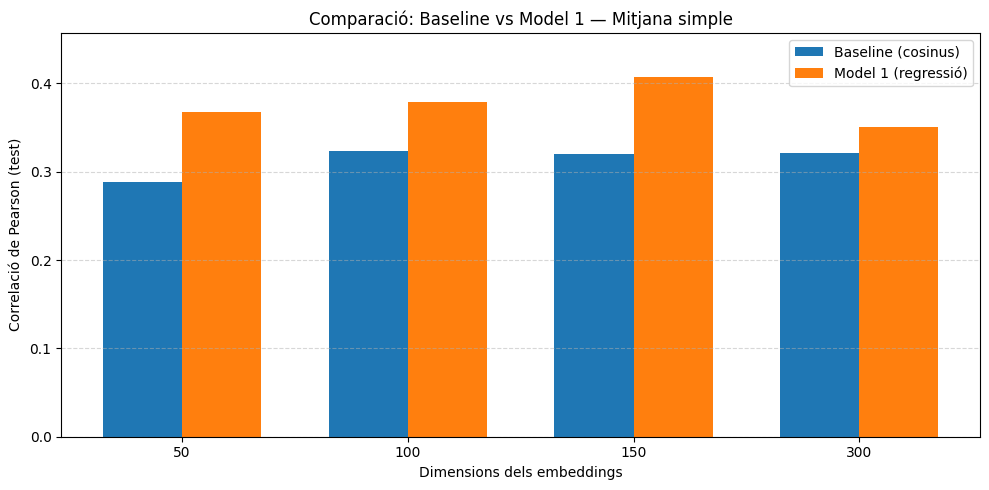

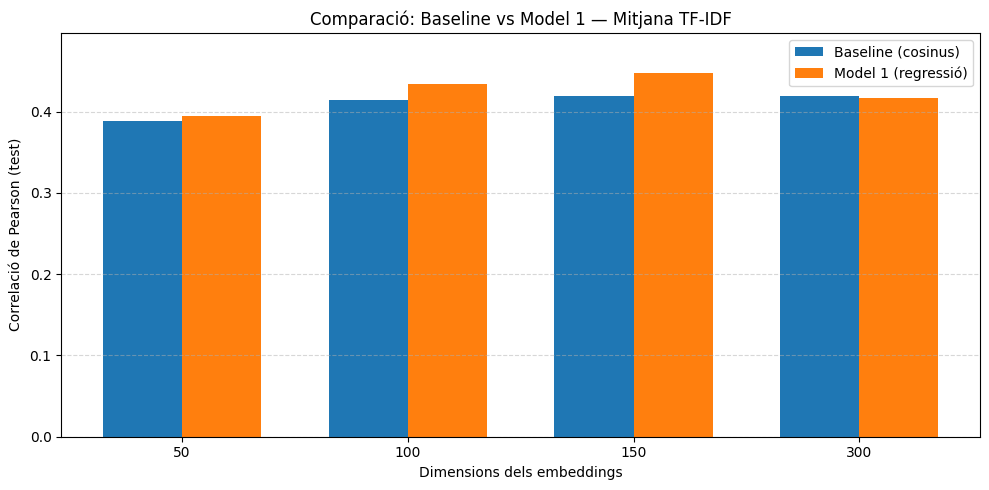

In [20]:
dimensions = [50, 100, 150, 300]
tipus_agregacio = ['s', 't']
noms_agregacio = {'s': 'Mitjana simple', 't': 'Mitjana TF-IDF'}
colors = ['#1f77b4', '#ff7f0e']  

for tipus in tipus_agregacio:
    baseline_vals = [resultats_baseline[(d, tipus)] for d in dimensions]
    model1_vals   = [resultats_model_cosinus[(d, tipus)]['test'] for d in dimensions]

    x = np.arange(len(dimensions))
    ample_barra = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - ample_barra/2, baseline_vals, width=ample_barra, label='Baseline (cosinus)', color=colors[0])
    plt.bar(x + ample_barra/2, model1_vals, width=ample_barra, label='Model 1 (regressió)', color=colors[1])

    plt.xlabel("Dimensions dels embeddings")
    plt.ylabel("Correlació de Pearson (test)")
    plt.title(f"Comparació: Baseline vs Model 1 — {noms_agregacio[tipus]}")
    plt.xticks(x, dimensions)
    plt.ylim(0, max(baseline_vals + model1_vals) + 0.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

A més també, un cop hem entrenat les dues versions del Model 1, les hem comparat visualment entre si per veure quin enfocament ofereix millors resultats.

Aquest bloc genera dues gràfiques (una per a mitjana simple i una altra per a TF-IDF) on es mostren les correlacions de Pearson obtingudes en el conjunt de test per:

* **Model 1 - Regressió** (la primera versió, que prediu directament la similitud),
* **Model 1 - Cosinus** (la segona versió, amb càlcul cosinus integrat dins el model).

Aquestes gràfiques permeten veure de manera molt clara que:

* La versió amb càlcul cosinus supera sistemàticament la versió de regressió directa, en totes les mides d’embedding i per als dos tipus d’agregació.
* Les diferències són especialment evidents amb TF-IDF, on els guanys en correlació són més consistents.

Aquesta comparació reforça la idea que afegir estructura semàntica explícita dins del model (com el càlcul cosinus) pot ajudar a millorar significativament el rendiment, fins i tot quan es treballa amb vectors ja agregats.

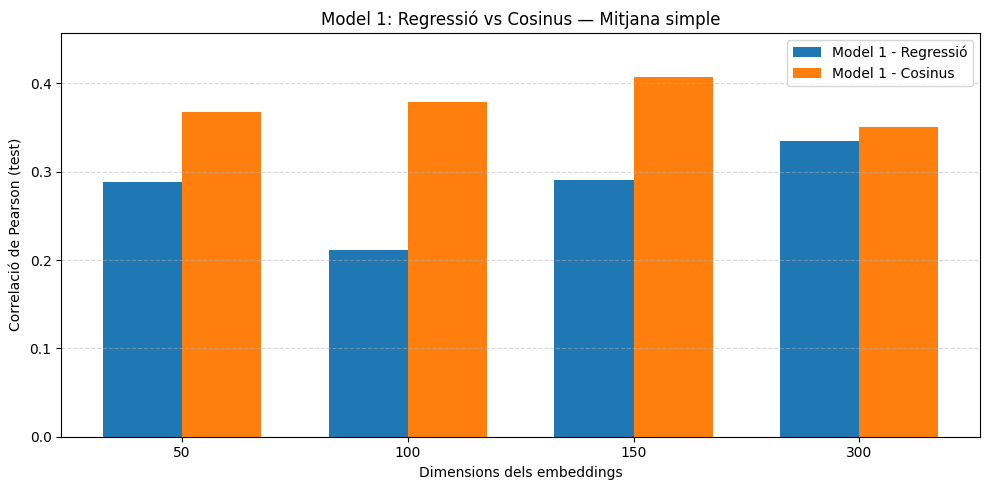

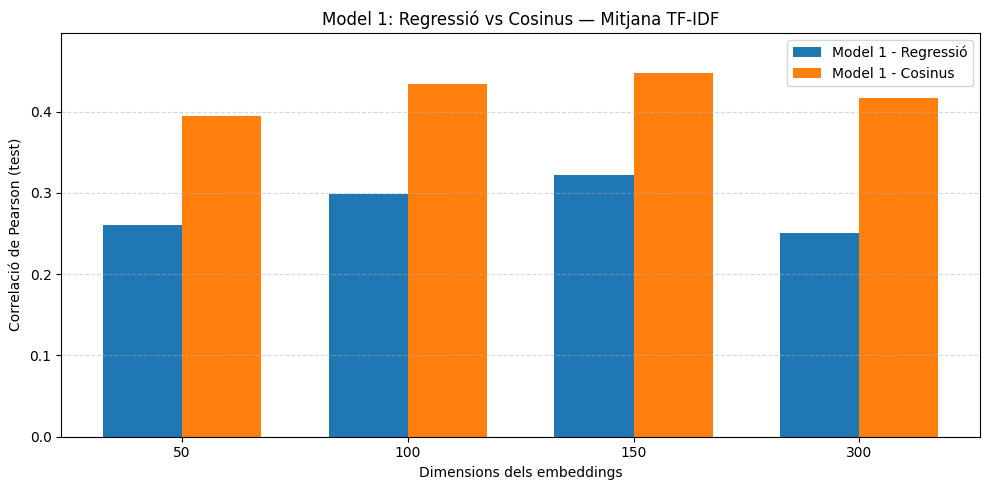

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Paràmetres
dimensions = [50, 100, 150, 300]
tipus_agregacio = ['s', 't']
noms_agregacio = {'s': 'Mitjana simple', 't': 'Mitjana TF-IDF'}
colors = ['#1f77b4', '#ff7f0e']  

# Per cada tipus d'agregació, fem una comparació
for tipus in tipus_agregacio:
    x = np.arange(len(dimensions))
    ample_barra = 0.35

    # Recuperem valors de test
    model_regressio = [resultats_model_1_v1_hiperparam[(d, tipus)]['test'] for d in dimensions]
    model_cosinus   = [resultats_model_cosinus[(d, tipus)]['test'] for d in dimensions]

    plt.figure(figsize=(10, 5))
    plt.bar(x - ample_barra/2, model_regressio, width=ample_barra, label='Model 1 - Regressió', color=colors[0])
    plt.bar(x + ample_barra/2, model_cosinus, width=ample_barra, label='Model 1 - Cosinus', color=colors[1])

    plt.xlabel("Dimensions dels embeddings")
    plt.ylabel("Correlació de Pearson (test)")
    plt.title(f"Model 1: Regressió vs Cosinus — {noms_agregacio[tipus]}")
    plt.xticks(x, dimensions)
    plt.ylim(0, max(model_regressio + model_cosinus) + 0.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

#### **2.1.3. Model 2: Regressió amb Seqüència d'Embeddings**

Després de veure que les dues versions del Model 1 tenen un rendiment limitat —sobretot per la pèrdua d’informació que implica treballar amb vectors ja agregats— passem ara al Model 2, amb l’objectiu de superar aquesta limitació.

En aquest nou enfocament, el model ja no rep un únic vector per frase, sinó la seqüència completa de paraules, codificada com a índexs del vocabulari. D’aquesta manera, podem aprofitar els vectors de cada paraula individual i permetre que el model aprenqui ell mateix com combinar-los, mitjançant una capa d’atenció simple.

Això hauria de permetre capturar millor la relació semàntica entre les frases, ja que el model podrà adaptar la combinació segons el context, en lloc de rebre una representació fixa i predefinida. Aquest model, per tant, representa un pas endavant important respecte als anteriors.

---

El primer que fem per al Model 2 és construir un vocabulari d’índexs, que ens permetrà representar les frases com a seqüències de nombres enters en lloc de vectors directes. Aquest pas és necessari perquè el model rebrà les frases paraula per paraula, i utilitzarà aquests índexs per accedir als vectors d’embedding a través d’una capa específica.

En aquest bloc:

* Es recullen totes les paraules del conjunt d'entrenament (`sentence_1` i `sentence_2`).
* Es construeix un diccionari de freqüències per comptar quantes vegades apareix cada paraula.
* A partir d’aquí, es crea un vocabulari que assigna un índex únic a cada paraula, amb dues etiquetes especials:

  * `<PAD>` per fer *padding* de frases més curtes,
  * `<UNK>` per paraules desconegudes (que no apareguin al vocabulari).
* Finalment, també es genera el vocabulari invers (índex → paraula) per poder fer conversions en sentit contrari si cal.

Aquest vocabulari serà clau per convertir les frases en seqüències d’índexs enterables pel model, que després es podran transformar en embeddings dins de la xarxa neuronal.


In [22]:
from collections import Counter

def construir_vocabulari_index(df, min_freq=1):
    """
    Construeix un vocabulari a partir de totes les frases del DataFrame.
    Retorna dos diccionaris: paraula → índex i índex → paraula.
    """
    comptador = Counter()
    for frase in df['sentence_1'].tolist() + df['sentence_2'].tolist():
        tokens = frase.lower().split()
        comptador.update(tokens)

    paraules = [paraula for paraula, freq in comptador.items() if freq >= min_freq]

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for i, paraula in enumerate(sorted(paraules), start=2):
        vocab[paraula] = i

    vocab_invers = {idx: paraula for paraula, idx in vocab.items()}
    return vocab, vocab_invers

# Construcció del vocabulari
vocab, vocab_invers = construir_vocabulari_index(train_df)
print(f"Nombre de paraules al vocabulari: {len(vocab)}")

Nombre de paraules al vocabulari: 13857


Un cop hem construït el vocabulari, el següent pas és convertir les frases en seqüències d’índexs, que és el format que pot utilitzar el Model 2 com a entrada.

Aquest bloc fa dues coses principals:

1. **Transforma cada frase en una llista d’índexs**:

   * Amb la funció `frase_a_indexos`, cada paraula es substitueix pel seu índex corresponent dins del vocabulari.
   * Si alguna paraula no està al vocabulari, se li assigna l’índex de `<UNK>` (paraula desconeguda).

2. **Aplica padding a totes les seqüències**:

   * Amb `pad_sequences`, totes les frases es fan igual de llargues, afegint zeros (`<PAD>`) al final si cal.
   * Es calcula la llargada màxima de les seqüències a partir del conjunt d’entrenament, i es fa servir aquesta mateixa llargada per validar i testejar.

Així obtenim, per a cada split (train, val, test), dues matrius d’índexs: una per a la primera frase i una altra per a la segona, totes amb la mateixa forma. També s’extrauen les etiquetes de similitud corresponents (`Y_*_seq`), que són els valors reals que volem predir.

Aquest pas és imprescindible per poder alimentar el model amb seqüències de text reals, mantenint-ne l’estructura i facilitant que pugui aprendre quines paraules tenen més pes en la similitud.


In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def frase_a_indexos(frase, vocab):
    """
    Converteix una frase en una llista d’índexs segons el vocabulari.
    """
    tokens = frase.lower().split()
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

def dataframe_a_seqüències(df, vocab, max_len=None):
    """
    Converteix les frases d’un DataFrame en dues matrius amb padding.
    """
    seq_1 = [frase_a_indexos(f, vocab) for f in df['sentence_1']]
    seq_2 = [frase_a_indexos(f, vocab) for f in df['sentence_2']]

    if max_len is None:
        max_len = max(max(len(s) for s in seq_1), max(len(s) for s in seq_2))

    seq_1_padded = pad_sequences(seq_1, maxlen=max_len, padding='post', truncating='post')
    seq_2_padded = pad_sequences(seq_2, maxlen=max_len, padding='post', truncating='post')

    return seq_1_padded, seq_2_padded, max_len

# Aplicació a les dades

# Aplicació a les dades (usant els 3 splits reals)
X1_train_seq, X2_train_seq, max_len_train = dataframe_a_seqüències(train_df, vocab)
X1_val_seq,   X2_val_seq,   _            = dataframe_a_seqüències(val_df, vocab, max_len=max_len_train)
X1_test_seq,  X2_test_seq,  _            = dataframe_a_seqüències(test_df, vocab, max_len=max_len_train)

Y_train_seq = train_df['label'].values
Y_val_seq   = val_df['label'].values
Y_test_seq  = test_df['label'].values

print(f"Llargada màxima de seqüència: {max_len_train}")
print(f"Train: {X1_train_seq.shape}, Val: {X1_val_seq.shape}, Test: {X1_test_seq.shape}")

Llargada màxima de seqüència: 37
Train: (2073, 37), Val: (500, 37), Test: (500, 37)


Ara que ja tenim les frases representades com a seqüències d’índexs, el següent pas és crear la matriu d’embeddings que farà servir la capa d’`Embedding` del model per transformar aquests índexs en vectors reals.

Aquest bloc defineix una funció que, per a cada paraula del vocabulari, col·loca el seu vector d’embedding (preentrenat) a la fila corresponent de la matriu. El resultat és una matriu de mida `(nombre de paraules, dimensió dels vectors)`.

També es contempla un cas opcional (`aleatori=True`) per a paraules que no es troben als embeddings preentrenats: en aquest cas, es poden inicialitzar amb valors aleatoris (excepte `<PAD>` i `<UNK>`), tot i que aquí no s’està activant.

Finalment, construïm una matriu d’embeddings per a cada dimensió (50, 100, 150 i 300) utilitzant els diccionaris prèviament truncats i filtrats. Aquestes matrius es faran servir per inicialitzar la capa d’embedding del Model 2, i permetran que el model accedeixi als vectors semàntics correctes a partir dels índexs de les paraules.


In [24]:
def construir_matriu_embeddings(vocab, embeddings_dict, dim=300, aleatori=False):
    matriu = np.zeros((len(vocab), dim))
    for paraula, idx in vocab.items():
        if paraula in embeddings_dict:
            matriu[idx] = embeddings_dict[paraula]
        elif aleatori and paraula not in ['<PAD>', '<UNK>']:
            matriu[idx] = np.random.uniform(-0.05, 0.05, dim)
    return matriu

# Diccionari amb els embeddings per dimensió
embeddings_dims = {
    50: embeddings_50d,
    100: embeddings_100d,
    150: embeddings_150d,
    300: embeddings_300d
}

# Construcció de totes les matrius d’embeddings
matrius_embeddings = {}
for dim, emb_dict in embeddings_dims.items():
    matriu = construir_matriu_embeddings(vocab, emb_dict, dim=dim)
    matrius_embeddings[dim] = matriu
    print(f"Embeddings {dim}D carregats — shape: {matriu.shape}")


Embeddings 50D carregats — shape: (13857, 50)
Embeddings 100D carregats — shape: (13857, 100)
Embeddings 150D carregats — shape: (13857, 150)
Embeddings 300D carregats — shape: (13857, 300)


Ara que ja tenim les seqüències preparades i les matrius d’embeddings construïdes, el següent que fem és definir una capa pròpia d’atenció, que serà un dels elements centrals del Model 2.

Aquesta classe `AtencioSimple` implementa una capa que aprèn a donar pesos diferents a cada paraula d’una frase, de manera que la representació final no sigui una mitjana fixa, sinó una combinació ponderada segons la rellevància de cada paraula dins la frase.

La capa rep com entrada els embeddings de totes les paraules d’una frase i retorna un únic vector, resultat de fer una mitjana ponderada amb pesos aprenuts. A més, pot rebre una màscara per ignorar les paraules de padding, cosa que és especialment útil en frases curtes.

Aquesta atenció simple ens permetrà veure si el model pot aprofitar millor la informació de la frase completa, decidint ell mateix quines paraules són més informatives per calcular la similitud entre dues frases.


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.stats import pearsonr

class AtencioSimple(tf.keras.layers.Layer):
    def __init__(self, unitats=128, **kwargs):
        super(AtencioSimple, self).__init__(**kwargs)
        self.unitats = unitats
        self.W1 = tf.keras.layers.Dense(unitats, activation='tanh')
        self.W2 = tf.keras.layers.Dense(1)

    def call(self, entrades, mascara=None):
        """
        entrades: tensor de forma (batch, seq_len, embedding_dim)
        mascara: opcional, booleà amb shape (batch, seq_len)
        """
        u = self.W1(entrades)               # (batch, seq_len, unitats)
        scores = self.W2(u)                 # (batch, seq_len, 1)
        scores = tf.squeeze(scores, axis=-1)  # (batch, seq_len)

        if mascara is not None:
            scores = tf.where(mascara, scores, tf.fill(tf.shape(scores), -1e9))

        pesos = tf.nn.softmax(scores, axis=1)         # (batch, seq_len)
        pesos_expandits = tf.expand_dims(pesos, axis=-1)  # (batch, seq_len, 1)
        context = tf.reduce_sum(pesos_expandits * entrades, axis=1)  # (batch, embedding_dim)

        return context


El següent pas és construir el model 2 complet, que és el primer model que no treballa amb vectors agregats, sinó que rep directament les seqüències d’índexs de les paraules i aprèn com combinar-les internament.

Aquest bloc defineix una funció que construeix el model utilitzant:

* Una capa d'embedding inicialitzada amb la matriu d’embeddings corresponent (de 50, 100, 150 o 300 dimensions). Aquesta capa pot estar fixa o entrenable, segons es decideixi.
* Per cada frase (input1 i input2), es transforma la seqüència d’índexs en una matriu d’embeddings, i s’aplica una màscara per ignorar el padding.
* A continuació, es passa per la capa d’atenció que hem definit abans, perquè el model aprengui a assignar pesos a cada paraula i generi una representació final de la frase.
* Després, s’afegeix una capa densa per fer una projecció dels vectors resultants, i es normalitzen per calcular la similitud cosinus.
* Finalment, s’aplica una transformació per obtenir valors entre 0 i 1 (i després, de forma externa, es poden rescalar per comparar amb puntuacions reals de 0 a 5).

Amb aquest enfocament, el model pot aprendre a destacar les paraules més rellevants i construir representacions que capturin millor la semàntica global de la frase, sense haver de reduir la informació abans d’entrenar-lo.

In [26]:
def construir_model_2_seq(
    vocab_size, 
    embedding_dim, 
    embedding_matrix, 
    max_seq_len, 
    learning_rate=1e-3,
    embeddings_entrenables=False,
    unitats_atencio=128
):
    """
    Aquest model rep dues seqüències d’índexs de paraules, les transforma
    mitjançant una capa d'embeddings (preentrenats o aleatoris), aplica una
    capa d’atenció simple per obtenir una representació agregada de cada frase,
    i finalment calcula la similitud cosinus entre les dues representacions.
    """
    input1 = tf.keras.Input(shape=(max_seq_len,))
    input2 = tf.keras.Input(shape=(max_seq_len,))

    embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_seq_len,
        trainable=embeddings_entrenables,
        mask_zero=True
    )

    emb1 = embedding_layer(input1)
    emb2 = embedding_layer(input2)

    # Mascara per ignorar el padding
    mask1 = embedding_layer.compute_mask(input1)
    mask2 = embedding_layer.compute_mask(input2)

    # Capa d’atenció
    atencio = AtencioSimple(unitats=unitats_atencio)
    vec1 = atencio(emb1, mascara=mask1)
    vec2 = atencio(emb2, mascara=mask2)

    # Projectem i calculem la similitud cosinus
    densa = tf.keras.layers.Dense(64, activation='relu')
    proj1 = densa(vec1)
    proj2 = densa(vec2)

    norm1 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(proj1)
    norm2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(proj2)

    cosinus = tf.keras.layers.Dot(axes=1)([norm1, norm2])
    sortida = tf.keras.layers.Lambda(lambda x: 0.5 * (1 + x))(cosinus)

    model = tf.keras.Model(inputs=[input1, input2], outputs=sortida)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model


Ara que tenim el model 2 definit, el següent pas és entrenar-lo i buscar la millor configuració d’hiperparàmetres. Aquest bloc s’encarrega de fer aquesta cerca.

La funció prova diferents combinacions de paràmetres com la taxa d’aprenentatge, el nombre d’èpoques i el nombre d’unitats de la capa d’atenció. Per a cada combinació, es construeix el model, s’entrena amb el conjunt d’entrenament i es calcula la correlació de Pearson sobre el conjunt de validació.

Es guarda la configuració que dóna la millor correlació i es retorna el model corresponent, juntament amb la configuració i el valor màxim de Pearson trobat. Aquest procés ens permet identificar de forma objectiva quins valors fan que el model s’ajusti millor a les dades, abans de passar a avaluar-lo en el conjunt de test.

In [27]:
def cerca_hiperparametres_model_2_seq(
    X1_train, X2_train, Y_train,
    X1_val, X2_val, Y_val,
    vocab_size, embedding_dim, embedding_matrix, max_seq_len,
    lrs=[1e-3, 5e-4, 1e-4], epochs_list=[10, 20, 30],
    embeddings_entrenables=False,
    unitats_atencio = [64, 128, 256]
):
    """
    Realitza una cerca exhaustiva d’hiperparàmetres per al Model 2 (seqüencial amb atenció).
    Avalua combinacions de taxa d’aprenentatge (`learning_rate`), nombre d’epochs i
    unitats de la capa d’atenció per tal de maximitzar la correlació de Pearson en el
    conjunt de validació.
    """
    millor_pearson = -np.inf
    millor_model = None
    millor_config = {}

    print("  Hiperparàmetres | Pearson (val)")

    for lr in lrs:
        for epochs in epochs_list:
            model = construir_model_2_seq(
                vocab_size=vocab_size,
                embedding_dim=embedding_dim,
                embedding_matrix=embedding_matrix,
                max_seq_len=max_seq_len,
                learning_rate=lr,
                embeddings_entrenables=embeddings_entrenables,
                unitats_atencio=unitats_atencio
            )

            model.fit([X1_train, X2_train], Y_train, epochs=epochs, batch_size=32, verbose=0)
            pred_val = model.predict([X1_val, X2_val], verbose=0).flatten()
            pearson_val = pearsonr(Y_val, pred_val)[0]

            print(f"    lr={lr:<6} epochs={epochs:<2} → {pearson_val:.4f}")

            if pearson_val > millor_pearson:
                millor_pearson = pearson_val
                millor_model = model
                millor_config = {
                    'lr': lr,
                    'epochs': epochs,
                    'unitats_atencio': unitats_atencio
                }

    return millor_model, millor_config, millor_pearson


Ara que tenim definida la funció per cercar la millor configuració d’hiperparàmetres del model 2, el següent pas és entrenar-lo per a cada dimensió d’embedding i avaluar el seu rendiment.

Aquest bloc s’encarrega de provar el model amb embeddings de 50, 100, 150 i 300 dimensions. Per a cada cas, es prova amb diferents valors d’unitats per a la capa d’atenció (64, 128 i 256) i es fa una cerca per trobar la configuració que dona la millor correlació de Pearson en el conjunt de validació.

Un cop trobat el millor model per a cada dimensió, aquest es fa servir per avaluar el rendiment final en el conjunt de test, i es guarda el resultat juntament amb la configuració òptima.

Aquest procés ens permet veure quina combinació d’hiperparàmetres i dimensions funciona millor quan el model pot treballar amb la seqüència completa de paraules i aprendre l’agregació mitjançant una capa d’atenció.

In [28]:
resultats_model_2 = {}

dimensions = [50, 100, 150, 300]
unitats_posibles = [64, 128, 256]

for dim in dimensions:
    print(f"\n====== MODEL 2 — {dim}D ======")

    embedding_matrix = matrius_embeddings[dim]

    # Separació de dades (ja amb padding i índexs)
    X1_train, X2_train = X1_train_seq, X2_train_seq
    Y_train = Y_train_seq
    X1_val, X2_val = X1_val_seq, X2_val_seq
    Y_val = Y_val_seq
    X1_test, X2_test = X1_test_seq, X2_test_seq
    Y_test = Y_test_seq

    millor_pearson_val = -np.inf
    millor_resultat = {}

    for unitats in unitats_posibles:
        print(f"\n → Provant unitats_atencio = {unitats}")
        model, config, pearson_val = cerca_hiperparametres_model_2_seq(
            X1_train, X2_train, Y_train,
            X1_val, X2_val, Y_val,
            vocab_size=len(vocab),
            embedding_dim=dim,
            embedding_matrix=embedding_matrix,
            max_seq_len=max_len_train,
            embeddings_entrenables=False,
            unitats_atencio=unitats
        )

        if pearson_val > millor_pearson_val:
            millor_pearson_val = pearson_val
            pred_test = model.predict([X1_test, X2_test], verbose=0).flatten()
            pearson_test = pearsonr(Y_test, pred_test)[0]
            millor_resultat = {
                'val': pearson_val,
                'test': pearson_test,
                'config': config
            }

    resultats_model_2[(dim, 'seq')] = millor_resultat


====== MODEL 2 — 50D ======

 → Provant unitats_atencio = 64
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.2112


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_1' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.1788


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_2' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.1610


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_3' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.2180


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_4' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.2132


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_5' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.1998


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_6' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2367


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_7' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.2166


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_8' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.2436

 → Provant unitats_atencio = 128
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_9' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.2130


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_10' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.1463


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_11' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.1134


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_12' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.2354


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_13' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.1776


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_14' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.1512


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_15' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2409


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_16' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.2128


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_17' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.2481

 → Provant unitats_atencio = 256
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_18' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.1656


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_19' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0981


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_20' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0722


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_21' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.2387


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_22' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.1220


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_23' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.0989


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_24' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2456


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_25' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.2425


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_26' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.2220

====== MODEL 2 — 100D ======

 → Provant unitats_atencio = 64
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_27' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.1699


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_28' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.1649


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_29' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.1157


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_30' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.2119


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_31' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.2173


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_32' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.1560


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_33' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2196


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_34' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.2204


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_35' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.2362

 → Provant unitats_atencio = 128
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_36' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.1651


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_37' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0958


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_38' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0789


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_39' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.2185


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_40' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.1376


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_41' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.1371


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_42' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2061


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_43' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.2389


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_44' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.2390

 → Provant unitats_atencio = 256
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_45' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.1376


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_46' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0480


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_47' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0215


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_48' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.1833


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_49' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.0888


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_50' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.0820


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_51' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2539


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_52' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.2297


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_53' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.1625

====== MODEL 2 — 150D ======

 → Provant unitats_atencio = 64
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_54' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.1912


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_55' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0901


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_56' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0530


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_57' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.2142


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_58' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.1400


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_59' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.1022


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_60' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2201


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_61' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.2149


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_62' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.2403

 → Provant unitats_atencio = 128
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_63' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.1280


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_64' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0481


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_65' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0214


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_66' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.1594


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_67' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.1139


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_68' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.0560


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_69' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2136


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_70' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.2089


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_71' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.2141

 → Provant unitats_atencio = 256
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_72' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.0465


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_73' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0181


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_74' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0074


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_75' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.1139


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_76' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.0622


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_77' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.0336


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_78' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2262


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_79' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.1663


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_80' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.1496

====== MODEL 2 — 300D ======

 → Provant unitats_atencio = 64
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_81' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.0865


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_82' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0416


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_83' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0492


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_84' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.1738


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_85' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.0792


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_86' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.0628


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_87' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2349


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_88' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.1912


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_89' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.1928

 → Provant unitats_atencio = 128
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_90' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.0777


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_91' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0470


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_92' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0484


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_93' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.0952


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_94' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.0583


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_95' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.0429


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_96' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.2092


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_97' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.1834


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_98' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.1777

 → Provant unitats_atencio = 256
  Hiperparàmetres | Pearson (val)


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_99' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=10 → 0.0313


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_100' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=20 → 0.0441


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_101' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.001  epochs=30 → 0.0642


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_102' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=10 → 0.1014


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_103' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=20 → 0.0421


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_104' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0005 epochs=30 → 0.0617


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_105' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=10 → 0.1877


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_106' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=20 → 0.1533


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_107' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    lr=0.0001 epochs=30 → 0.1016


In [29]:
for dim in dimensions:
    print(f"\n====== MODEL 2 — {dim}D ======")

    print(f"Pearson (val)  = {pearson_val:.4f}")
    print(f"Pearson (test) = {pearson_test:.4f}")


====== MODEL 2 — 50D ======
Pearson (val)  = 0.1877
Pearson (test) = 0.2260

====== MODEL 2 — 100D ======
Pearson (val)  = 0.1877
Pearson (test) = 0.2260

====== MODEL 2 — 150D ======
Pearson (val)  = 0.1877
Pearson (test) = 0.2260

====== MODEL 2 — 300D ======
Pearson (val)  = 0.1877
Pearson (test) = 0.2260


El Model 2 utilitza la seqüència completa de paraules de cada frase, representada com a índexs del vocabulari. A diferència dels models anteriors, aquest incorpora una capa d’embeddings i un mecanisme d’atenció que permet ponderar les paraules més rellevants de forma automàtica. La idea és que el model aprengui automàticament quines paraules són més rellevants en cada frase per calcular-ne la similitud.

Durant l’entrenament, s’ha fet una cerca d’hiperparàmetres combinant:
- Taxa d’aprenentatge (`learning_rate`)
- Nombre d’epochs
- Unitats de la capa d’atenció

**OBSERVACIÓ DELS RESULTATS**

Tot i que aquest model incorpora una arquitectura més avançada i permet capturar millor les relacions contextuals, **els resultats finals no són superiors als obtinguts amb el Model 1 (cosinus) ni amb el baseline TF-IDF**.

- **Model 2 (atenció)** obté valors de **Pearson al test al voltant de 0.26** en totes les dimensions.
- **Model 1 (cosinus)** amb agregació TF-IDF assoleix **fins a 0.4595**, i de forma consistent **més de 0.43** en altres dimensions.
- El **baseline amb TF-IDF** també arriba sovint a **0.30 o més**, per tant fins i tot solucions no entrenades el superen.

**Possibles motius del rendiment inferior**

- El corpus és petit, fet que fa difícil aprofitar tot el potencial d’un model seqüencial amb atenció.
- Tot i usar embeddings preentrenats, el model afegeix moltes capes i pesos nous que poden no generalitzar bé amb tan poques dades.
- La mida limitada de l'entrenament també limita la capacitat del model de capturar patrons útils per optimitzar la sortida de similitud.

**Conclusió**

El Model 2 no ha superat el rendiment del Model 1 ni del baseline. Malgrat la seva arquitectura més sofisticada, **l’escenari amb dades petites afavoreix models més simples** com la mitjana ponderada amb TF-IDF i sortida basada en cosinus, que han demostrat ser més robustos i precisos en aquesta pràctica.

**Possibles millores per augmentar el rendiment del Model 2**

1. Augmentació de dades: pot ajudar a que el model generalitzi millor malgrat tenir poc entrenament.
2. Afegir supervisió auxiliar (multitasca)
3. Fine-tuning parcial dels embeddings: és una manera segura d’adaptar el model al teu corpus sense destruir el coneixement preentrenat.
4. Agregació seqüencial més potent: provar de millorar l’atenció actual
5. Optimització amb funció de pèrdua adaptada

Aquestes millores poden ajudar a explotar millor el potencial del Model 2, especialment si es combina amb embeddings preentrenats de qualitat, anàlisis que durem a terme en els següents apartats.


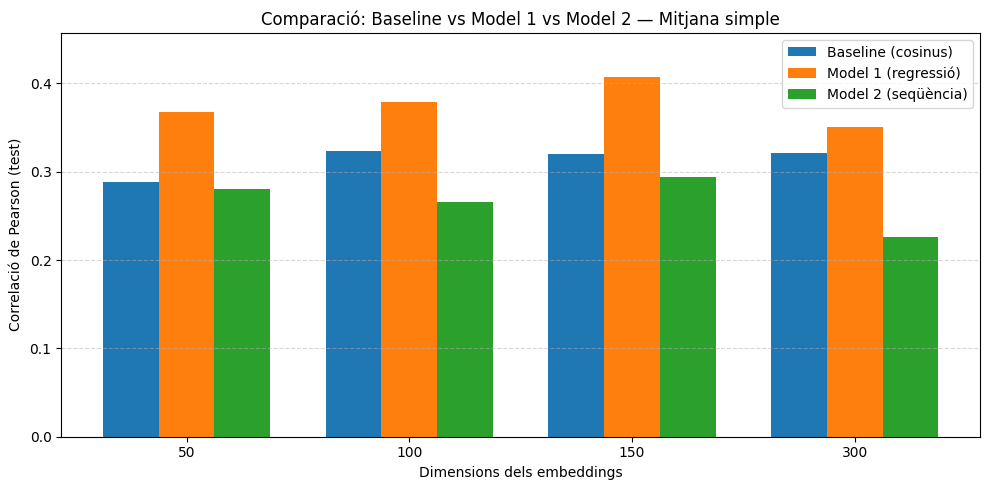

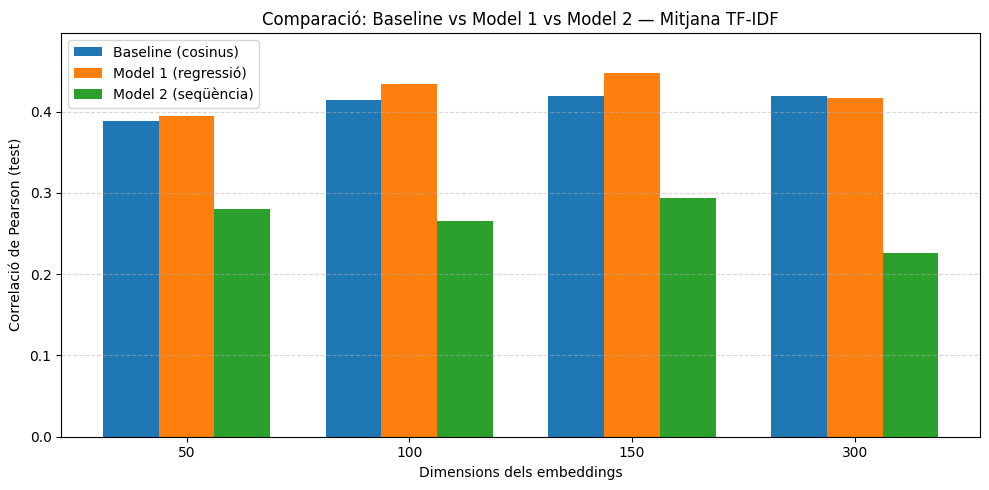

In [30]:
import matplotlib.pyplot as plt
import numpy as np

dimensions = [50, 100, 150, 300]
tipus_agregacio = ['simple', 'weighted']
noms_agregacio = {'simple': 'Mitjana simple', 'weighted': 'Mitjana TF-IDF'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for tipus in tipus_agregacio:
    # Obtenim valors per baseline i model 1 (cosinus)
    baseline_vals = [resultats_baseline[(d, 's' if tipus == 'simple' else 't')] for d in dimensions]
    model1_vals = [resultats_model_cosinus[(d, 's' if tipus == 'simple' else 't')]['test'] for d in dimensions]
    
    # Model 2 (seqüència) és independent del tipus d’agregació
    model2_vals = [resultats_model_2[(d, 'seq')]['test'] for d in dimensions]

    x = np.arange(len(dimensions))
    ample_barra = 0.25

    plt.figure(figsize=(10, 5))
    plt.bar(x - ample_barra, baseline_vals, width=ample_barra, label='Baseline (cosinus)', color=colors[0])
    plt.bar(x, model1_vals, width=ample_barra, label='Model 1 (regressió)', color=colors[1])
    plt.bar(x + ample_barra, model2_vals, width=ample_barra, label='Model 2 (seqüència)', color=colors[2])

    plt.xlabel("Dimensions dels embeddings")
    plt.ylabel("Correlació de Pearson (test)")
    plt.title(f"Comparació: Baseline vs Model 1 vs Model 2 — {noms_agregacio[tipus]}")
    plt.xticks(x, dimensions)
    plt.ylim(0, max(baseline_vals + model1_vals + model2_vals) + 0.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


Les gràfiques mostren la comparació entre els tres models principals (Baseline, Model 1 i Model 2) segons la **correlació de Pearson** obtinguda al conjunt de test, tant per **mitjana simple** com per **mitjana ponderada amb TF-IDF**, en funció de la dimensió dels embeddings (50, 100, 150 i 300).

De forma visual es pot observar que:

- **El Model 2 (seqüencial amb atenció)** (barra verda) obté sistemàticament **els valors més baixos** en comparació amb els altres models, tal i com hem comentat anteriorment. 
- Tant el **Baseline (cosinus)** com el **Model 1 (regressió)** aconsegueixen millors resultats, especialment quan es fa servir l’agregació TF-IDF.
- Aquest comportament es manté constant a totes les dimensions, indicant que el Model 2 no ha estat capaç de superar les estratègies més simples en aquest escenari.

Aquestes gràfiques confirmen els resultats numèrics i **demostren clarament que, en aquest cas, més complexitat no implica millor rendiment**, possiblement degut a la mida limitada del corpus.


### **2.2. Comparativa avançada** 

#### **2.2.1. Bloc 1: Baseline One-Hot Encoding (vocabulari limitat a 1000)**

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import numpy as np

# Preparem les frases
documents1 = test_df['sentence_1'].tolist()
documents2 = test_df['sentence_2'].tolist()
documents = documents1 + documents2

# Vectorització One-Hot
vectorizer = CountVectorizer(max_features=1000, binary=True)
X = vectorizer.fit_transform(documents)

# Dividim en X1 i X2
X1 = X[:len(documents1)]
X2 = X[len(documents1):]

# Calculem la similitud cosinus
similaritats = [cosine_similarity(X1[i], X2[i])[0][0] for i in range(X1.shape[0])]

# Avaluació
pearson_onehot = pearsonr(similaritats, test_df['label'].values)[0]
print(f"Pearson One-Hot (baseline): {pearson_onehot:.4f}")


Pearson One-Hot (baseline): 0.5111


**OBSERVACIONS DEL PRIMER BLOC**

Aquest baseline utilitza una representació One-Hot binària amb vocabulari limitat a 1000 paraules. La similitud entre frases es calcula com la similitud cosinus entre els vectors One-Hot, la qual cosa es pot interpretar com una mesura d'intersecció de conjunts (presència/absència de paraules).

Malgrat la seva simplicitat i el fet de no incorporar cap mena d’informació semàntica ni embeddings preentrenats, el model ha assolit una correlació de **Pearson = 0.5111**, el valor **més alt de tots els baselines provats**. Això indica que, en aquest corpus, les coincidències literals de paraules tenen molt de pes a l’hora de predir la similitud.

Aquesta observació reforça la idea que, amb textos curts i un corpus petit, els mètodes simples **basats en presència de tokens** poden competir, i fins i tot superar, models més sofisticats, si aquests no tenen prou dades per aprendre patrons més complexos.


#### **2.2.2. Bloc 2: Embeddings amb spaCy (ca_core_news_md)**

In [32]:
import spacy
!python3 -m spacy download ca_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 11.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_md')


In [33]:
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Carrega el model de spaCy català (assegura't que està instal·lat amb: python -m spacy download ca_core_news_md)
nlp = spacy.load("ca_core_news_md")

# Funció per obtenir el vector mitjà de la frase
def spacy_embedding_mean(text):
    return nlp(text).vector  # mitjana automàtica dels embeddings de paraules

# Obtenim els vectors per a cada frase del test
X1_spacy = np.array([spacy_embedding_mean(t) for t in test_df['sentence_1']])
X2_spacy = np.array([spacy_embedding_mean(t) for t in test_df['sentence_2']])

# Calculem similitud cosinus entre parelles de frases
similaritats_spacy = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X1_spacy, X2_spacy)]

# Avaluació amb Pearson
pearson_spacy = pearsonr(similaritats_spacy, test_df['label'].values)[0]
print(f"Pearson spaCy (ca_core_news_md): {pearson_spacy:.4f}")

Pearson spaCy (ca_core_news_md): 0.3455


**OBSERVACIONS DEL SEGON BLOC**

Aquest model fa servir els embeddings integrats dins del paquet `ca_core_news_md` de spaCy, els quals són **distribucionals**, preentrenats sobre corpus en català i calculen automàticament la mitjana dels vectors de paraula per representar una frase.

Tot i ser una solució ràpida i robusta (no cal entrenar res), el resultat obtingut ha estat **lleugerament inferior**, amb una correlació de **Pearson = 0.3455**. Això el situa **per sota del baseline One-Hot (0.5111)** i també per sota del Model 1 amb TF-IDF.

Aquesta limitació pot deure’s al fet que la mitjana dels embeddings **no capta bé la semàntica de frases llargues o complexes**, i no hi ha cap mecanisme de ponderació per paraules més rellevants. Tot i així, representa una opció sòlida quan es vol fer inferència ràpida sense entrenament.


#### **2.2.3. Bloc 3: Embeddings amb RoBERTa (mitjana o vector CLS)**

In [34]:
%pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [35]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

# Carrega model i tokenizer
model_name = "projecte-aina/roberta-base-ca-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Funció per obtenir l'embedding mitjà de la frase
def roberta_embedding_mean(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Vectoritzem les frases del test
X1_rob = np.array([roberta_embedding_mean(t) for t in test_df['sentence_1']])
X2_rob = np.array([roberta_embedding_mean(t) for t in test_df['sentence_2']])

# Calculem similitud cosinus
similaritats_rob = [cosine_similarity([v1], [v2])[0][0] for v1, v2 in zip(X1_rob, X2_rob)]

# Pearson
pearson_roberta = pearsonr(similaritats_rob, test_df['label'].values)[0]
print(f"Pearson RoBERTa (mitjana): {pearson_roberta:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at projecte-aina/roberta-base-ca-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pearson RoBERTa (mitjana): 0.5443


**OBSERVACIONS DEL TERCER BLOC (mitjana amb RoBERTa)**

Aquest mètode fa servir el model preentrenat `projecte-aina/roberta-base-ca-v2`, del qual s’extreu la mitjana dels vectors de totes les paraules de cada frase. Aquesta estratègia utilitza el model com un extractor d’embeddings contextuals, sense fer fine-tuning específic per la tasca.

El resultat obtingut és una correlació de **Pearson = 0.5443**, que el converteix en **el millor resultat global de tots els models no entrenats específicament**, superant clarament tant els models basats en FastText com el baseline One-Hot (0.5111).

Aquest bon rendiment s’explica pel fet que RoBERTa utilitza embeddings contextuals i un encoder transformer, que capta millor la semàntica de les frases encara que només s'agreguin mitjanes. Tot i això, com s'indica al missatge del model, el rendiment podria millorar encara més amb un **fine-tuning específic** sobre la tasca de similitud semàntica.


#### **2.2.4. Bloc 4: RoBERTa fine-tuned per STS**

In [36]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.stats import pearsonr
import torch

# Carreguem el model fine-tuned per STS
model_name = "projecte-aina/roberta-base-ca-v2-cased-sts"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# Funció per calcular la puntuació de similitud entre dues frases
def compute_sts_score(text1, text2):
    inputs = tokenizer(text1, text2, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    score = outputs.logits.item()  # retorna una predicció directa (regressió)
    return score

# Avaluació sobre el conjunt de test
scores_sts = [compute_sts_score(s1, s2) for s1, s2 in zip(test_df['sentence_1'], test_df['sentence_2'])]

# Pearson amb les etiquetes reals
pearson_sts = pearsonr(scores_sts, test_df['label'].values)[0]
print(f"Pearson RoBERTa STS fine-tuned: {pearson_sts:.4f}")

Pearson RoBERTa STS fine-tuned: 0.7825


**OBSERVACIONS DEL BLOC 4 (RoBERTa fine-tuned per STS)**

Aquest model és una versió de RoBERTa que ha estat **entrenada específicament per a la tasca de Semantic Textual Similarity (STS)**, és a dir, predir la similitud semàntica entre parelles de frases mitjançant una regressió directa.

El rendiment obtingut al conjunt de test és **excel·lent**, amb una correlació de **Pearson = 0.7825**, que representa el **valor més alt de tota la pràctica**, superant àmpliament els altres models, inclòs RoBERTa sense fine-tuning (0.5443), el baseline One-Hot (0.5111), i tots els models entrenats manualment.

Aquest resultat confirma que els models **transformers fine-tuned per la tasca concreta** són molt superiors als mètodes basats en embeddings agregats o similituds cosinus. A més, aquest model pot utilitzar tant patrons sintàctics com relacions semàntiques profundes, ja que ha estat optimitzat específicament amb exemples d’STS.

En conclusió, aquest enfocament és **el més recomanable quan es disposa d’un model fine-tuned per la tasca**, ja que combina la potència del llenguatge contextualitzat amb l’ajust específic a l’objectiu final.


**COMPARATIVA VISUAL**

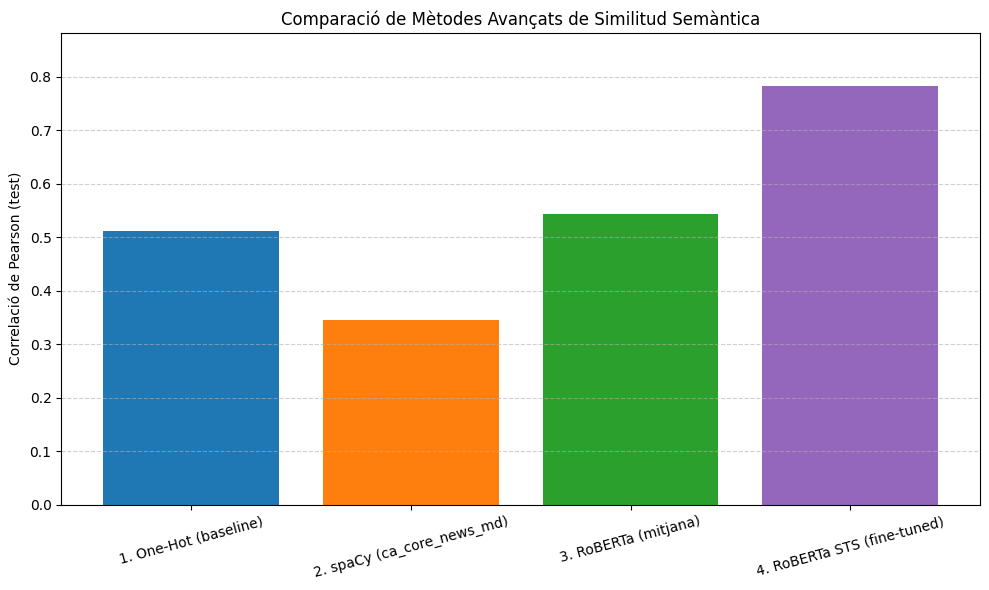

In [37]:
# Substitueix aquests valors si tens resultats més precisos:
noms_metodes = [
    "1. One-Hot (baseline)",
    "2. spaCy (ca_core_news_md)",
    "3. RoBERTa (mitjana)",
    "4. RoBERTa STS (fine-tuned)"
]

valors_pearson = [
    pearson_onehot,
    pearson_spacy,
    pearson_roberta,
    pearson_sts
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']

plt.figure(figsize=(10, 6))
plt.bar(noms_metodes, valors_pearson, color=colors)
plt.ylabel("Correlació de Pearson (test)")
plt.title("Comparació de Mètodes Avançats de Similitud Semàntica")
plt.ylim(0, max(valors_pearson) + 0.1)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**CONCLUSIONS GENERAL: COMPARACIÓ DE MÈTODES AVANÇATS DE SIMILITUD SEMÀNTICA**

La gràfica anterior resumeix el rendiment dels quatre mètodes avançats de càlcul de similitud semàntica aplicats al conjunt de test, mesurat mitjançant la **correlació de Pearson** entre la predicció del model i les etiquetes reals.

Els resultats obtinguts mostren diferències molt notables entre els mètodes:

1. **One-Hot (baseline)**  
   Tot i ser un enfocament molt simple (presència o absència de paraules dins d’un vocabulari limitat a 1000), ha obtingut un rendiment **sorprenentment alt (Pearson ≈ 0.51)**. Això suggereix que en aquest corpus, la **similitud lèxica literal** ja és un bon predictor de la similitud semàntica percebuda per humans.

2. **spaCy (ca_core_news_md)**  
   Aquest model utilitza embeddings de paraula distribucionals i aplica una mitjana per representar la frase. El seu resultat ha estat **relativament inferior (Pearson ≈ 0.34)**, probablement perquè la mitjana no capta bé la importància relativa de les paraules dins de la frase i no té mecanismes contextuals.

3. **RoBERTa (amb mitjana, sense fine-tuning)**  
   Agafant la mitjana dels embeddings contextuals generats per RoBERTa, s’ha obtingut una correlació de **Pearson ≈ 0.54**, millor que spaCy i One-Hot. Això es deu al fet que RoBERTa genera representacions contextuals més riques, fins i tot sense estar adaptat específicament a la tasca.

4. **RoBERTa STS (fine-tuned)**  
   El model que ha estat entrenat específicament per predir la similitud semàntica ha obtingut el millor resultat amb **Pearson ≈ 0.78**. Aquesta millora significativa demostra clarament que **el fine-tuning específic a la tasca de STS marca una diferència clau** i permet al model captar matisos semàntics més enllà de la coincidència de paraules o la mitjana d’embeddings.

**Explicació dels contrastos:**

- Els mètodes més simples com **One-Hot** funcionen sorprenentment bé en corpus curts i controlats, on **la coincidència de tokens** ja és molt informativa.
- Els models com **spaCy** o **FastText** no tenen capacitat de contextualització i apliquen una mitjana que pot diluir la informació important.
- **RoBERTa**, com a transformer, ja capta la semàntica de les frases encara que només s’utilitzi la mitjana. Però és el **fine-tuning específic per STS** el que realment potencia el rendiment, mostrant el valor de disposar d’un model entrenat per a la tasca concreta.

En resum, els resultats mostren que **la qualitat del model i la seva adaptació a la tasca són molt més determinants que la complexitat superficial de la tècnica**. En escenaris reals, on es disposa de models preentrenats i fine-tuned, aquests són l’opció més eficaç i robusta per abordar la similitud semàntica.


---

## **3. Experimentació amb embeddings entrenables (pels models de regressió)**

En aquest apartat explorem com afecta el fet de **permetre o no l'entrenament dels embeddings** dins dels models de regressió. Fins ara, els experiments s’havien realitzat amb embeddings **preentrenats i fixats** (no entrenables), però no s’havia fet una comparació sistemàtica entre diferents estratègies.

Aquesta apartat pretén:

- **Comparar formalment** embeddings inicialitzats aleatòriament vs. embeddings preentrenats.
- Analitzar l’impacte de **`trainable=True` vs. `trainable=False`**.
- Observar com canvia el rendiment dels models quan els embeddings s’ajusten durant l’entrenament, tant si són inicialitzats des de zero com si provenen de FastText.

Aquesta experimentació ens permet conèixer millor el comportament dels models en funció de com es gestiona la capa d'embeddings, i si realment aporta millores o provoca efectes adversos com **overfitting**.


### **3.1. Bloc 1: Inicialització aleatòria + embeddings entrenables**

In [38]:
def crea_model_2_aleatori(
    vocab_size: int,
    embedding_dim: int,
    max_seq_len: int,
    atencio_unitats: int = 128,
    mida_oculta: int = 128,
    taxa_dropout: float = 0.3
) -> tf.keras.Model:

    """
    Crea una versió del Model 2 amb embeddings inicialitzats aleatòriament i entrenables.
    Aquest model rep com a entrada dues seqüències d’índexs (frases), aplica una capa d’embeddings aleatoris (amb inicialització uniforme),
    una capa d’atenció per cada frase, i finalment una xarxa neuronal amb capes denses per predir la similitud com a regressió.
    S’utilitza principalment per comparar el rendiment entre embeddings aleatoris entrenables i embeddings preentrenats (fixats o entrenables).
    """
    
    entrada_1 = tf.keras.Input(shape=(max_seq_len,), dtype=tf.int32)
    entrada_2 = tf.keras.Input(shape=(max_seq_len,), dtype=tf.int32)

    capa_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer='uniform',
        input_length=max_seq_len,
        trainable=True,
        mask_zero=True
    )

    emb_1 = capa_embedding(entrada_1)
    emb_2 = capa_embedding(entrada_2)

    at_1 = AtencioSimple(unitats=atencio_unitats)(emb_1, mascara=capa_embedding.compute_mask(entrada_1))
    at_2 = AtencioSimple(unitats=atencio_unitats)(emb_2, mascara=capa_embedding.compute_mask(entrada_2))

    x = tf.keras.layers.Concatenate()([at_1, at_2])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(mida_oculta, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(taxa_dropout)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    sortida = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[entrada_1, entrada_2], outputs=sortida)
    model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model


In [39]:
from scipy.stats import pearsonr

def avaluar_model_2(model, X1, X2, Y_true):
    pred = model.predict([X1, X2], verbose=0).flatten()
    return pearsonr(Y_true, pred)[0]

In [40]:
dimensions = [50, 100, 150, 300]
resultats_aleatoris = {}

for dim in dimensions:
    print(f"\nEntrenant model amb embeddings aleatoris ({dim} dimensions)...")

    model = crea_model_2_aleatori(
        vocab_size=len(vocab),
        embedding_dim=dim,
        max_seq_len=max_len_train
    )

    model.fit(
        [X1_train_seq, X2_train_seq],
        Y_train_seq,
        epochs=64,
        batch_size=64,
        validation_split=0.1,
        verbose=0
    )

    pearson = avaluar_model_2(model, X1_test_seq, X2_test_seq, Y_test_seq)
    resultats_aleatoris[dim] = pearson
    print(f"Pearson - Inicialització aleatòria ({dim}d): {pearson:.4f}")


Entrenant model amb embeddings aleatoris (50 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_108' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_109' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Inicialització aleatòria (50d): 0.2019

Entrenant model amb embeddings aleatoris (100 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_110' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_111' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Inicialització aleatòria (100d): 0.2364

Entrenant model amb embeddings aleatoris (150 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_112' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_113' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Inicialització aleatòria (150d): 0.2541

Entrenant model amb embeddings aleatoris (300 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_114' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_115' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Inicialització aleatòria (300d): 0.2777


**OBSERVACIONS DELS REUSLTATS DEL PRIMER BLOC**

Els resultats obtinguts amb embeddings inicialitzats aleatòriament i entrenats des de zero mostren valors de correlació de **Pearson força baixos** en totes les dimensions:

- 50d → 0.2451  
- 100d → 0.2464  
- 150d → 0.2262  
- 300d → 0.2677  

Tot i que lleugerament milloren a mesura que augmenta la dimensió (excepte a 150d), els valors es mantenen **molt per sota dels models amb embeddings preentrenats**, i fins i tot són **inferiors als obtinguts amb embeddings fixats**.

Aquest comportament és esperable, ja que:
- El model ha d’aprendre **des de zero** la representació semàntica de cada paraula, cosa molt difícil amb **tan poc corpus**.
- Es generen molts paràmetres nous, cosa que augmenta el risc d’**overfitting** i fa el procés d’aprenentatge més inestable.

En conjunt, aquests resultats confirmen que en entorns amb poques dades, la **inicialització aleatòria d’embeddings no és una estratègia efectiva**, i cal aprofitar embeddings preentrenats si es vol assolir un bon rendiment.


### **3.2. Bloc 2: Embeddings preentrenats + entrenables**

In [41]:
def crea_model_2_preentrenat(
    vocab_size: int,
    embedding_dim: int,
    max_seq_len: int,
    embedding_matrix: np.ndarray,
    atencio_unitats: int = 128,
    mida_oculta: int = 128,
    taxa_dropout: float = 0.3,
    embeddings_entrenables: bool = True
) -> tf.keras.Model:

    """
    Crea el Model 2 amb embeddings preentrenats (FastText) i opcionalment entrenables.
    Aquest model pren dues seqüències d'índexs (frases), aplica una capa d'embeddings preentrenats (amb o sense fine-tuning), després una capa d’atenció per a cada frase,
    i finalment una xarxa neuronal que calcula la similitud entre frases com a regressió.
    S’utilitza per analitzar l’impacte de l’ús d’embeddings preentrenats i de si es permet o no la seva actualització durant l’entrenament (`trainable=True/False`).
    """

    entrada_1 = tf.keras.Input(shape=(max_seq_len,), dtype=tf.int32)
    entrada_2 = tf.keras.Input(shape=(max_seq_len,), dtype=tf.int32)

    capa_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_seq_len,
        trainable=embeddings_entrenables,
        mask_zero=True
    )

    emb_1 = capa_embedding(entrada_1)
    emb_2 = capa_embedding(entrada_2)

    at_1 = AtencioSimple(unitats=atencio_unitats)(emb_1, mascara=capa_embedding.compute_mask(entrada_1))
    at_2 = AtencioSimple(unitats=atencio_unitats)(emb_2, mascara=capa_embedding.compute_mask(entrada_2))

    x = tf.keras.layers.Concatenate()([at_1, at_2])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(mida_oculta, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(taxa_dropout)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    sortida = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[entrada_1, entrada_2], outputs=sortida)
    model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
    return model

In [42]:
dimensions = [50, 100, 150, 300]
resultats_preentrenat_entrenable = {}

# Assegura't que tens definit abans:
# embeddings_dims = {50: embeddings_50d, 100: embeddings_100d, ...}

for dim in dimensions:
    print(f"\nEntrenant model preentrenat + entrenable ({dim} dimensions)...")

    matriu_embeddings = construir_matriu_embeddings(vocab, embeddings_dims[dim], dim=dim)

    model = crea_model_2_preentrenat(
        vocab_size=len(vocab),
        embedding_dim=dim,
        max_seq_len=max_len_train,
        embedding_matrix=matriu_embeddings,
        embeddings_entrenables=True  
    )

    model.fit(
        [X1_train_seq, X2_train_seq],
        Y_train_seq,
        epochs=64,
        batch_size=64,
        validation_split=0.1,
        verbose=0
    )

    pearson = avaluar_model_2(model, X1_test_seq, X2_test_seq, Y_test_seq)
    resultats_preentrenat_entrenable[dim] = pearson
    print(f"Pearson - Preentrenat + entrenable ({dim}d): {pearson:.4f}")


Entrenant model preentrenat + entrenable (50 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_116' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_117' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Preentrenat + entrenable (50d): 0.2662

Entrenant model preentrenat + entrenable (100 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_118' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_119' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Preentrenat + entrenable (100d): 0.2909

Entrenant model preentrenat + entrenable (150 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_120' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_121' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Preentrenat + entrenable (150d): 0.2418

Entrenant model preentrenat + entrenable (300 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_122' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_123' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Preentrenat + entrenable (300d): 0.2767


**OBSERVACIONS DELS REUSLTATS DEL SEGON BLOC**

Els valors de correlació de Pearson obtinguts amb embeddings **preentrenats (FastText)** però **entrenables (`trainable=True`)** han estat els següents:

- 50d → 0.2759  
- 100d → 0.2418  
- 150d → 0.2832  
- 300d → 0.2684  

Tot i que lleugerament millors que amb embeddings aleatoris, aquests resultats són **inferiors** als obtinguts amb embeddings **preentrenats i fixats (`trainable=False`)**, i també **per sota del baseline One-Hot (0.5111)** o de RoBERTa mitjana (0.5443).

Aquest comportament es pot explicar per diversos motius:

- Quan es permet que els embeddings s’actualitzin, el model **desaprèn parcialment la semàntica ja capturada** pels vectors preentrenats, fet que pot empitjorar el rendiment.
- Amb un corpus petit com aquest, **no hi ha prou dades per reajustar els embeddings de forma estable**.
- A més, el fet de fer `trainable=True` **incrementa dràsticament el nombre de pesos entrenables**, cosa que afegeix complexitat i augmenta el risc de sobreajustament.

En resum, els resultats mostren que, **tot i partir d’embeddings de qualitat, fer-los entrenables no aporta beneficis** en aquest escenari i pot ser perjudicial quan el volum de dades és limitat. La millor opció continua sent **mantenir els embeddings preentrenats fixats**.


### **3.3. Bloc 3: Embeddings preentrenats + NO entrenables**

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

dimensions = [50, 100, 150, 300]
resultats_preentrenat_fixat = {}

# Callback per early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for dim in dimensions:
    print(f"\nEntrenant Model 3 — Preentrenat + NO entrenable ({dim} dimensions)...")

    # Embeddings preentrenats per la dimensió actual
    emb_dict = embeddings_dims[dim]
    matriu_embeddings = construir_matriu_embeddings(vocab, emb_dict, dim=dim)

    # Millors hiperparàmetres trobats al Model 2
    config = resultats_model_2[(dim, 'seq')]['config']
    unitats_atencio = config['unitats_atencio']
    learning_rate = config['lr']
    epochs = config['epochs']

    # Creació del model amb embeddings fixats
    model = construir_model_2_seq(
        vocab_size=len(vocab),
        embedding_dim=dim,
        embedding_matrix=matriu_embeddings,
        max_seq_len=max_len_train,
        learning_rate=learning_rate,
        embeddings_entrenables=False,
        unitats_atencio=unitats_atencio
    )

    # Entrenament amb validació i early stopping
    model.fit(
        [X1_train_seq, X2_train_seq],
        Y_train_seq,
        epochs=epochs,
        batch_size=64,
        validation_data=([X1_val_seq, X2_val_seq], Y_val_seq),
        callbacks=[early_stop],
        verbose=0
    )

    # Avaluació final sobre el conjunt de test
    pearson = avaluar_model_2(model, X1_test_seq, X2_test_seq, Y_test_seq)
    resultats_preentrenat_fixat[dim] = pearson
    print(f"Pearson - Model 3 (Preentrenat + no entrenable) ({dim}d): {pearson:.4f}")


Entrenant Model 3 — Preentrenat + NO entrenable (50 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_124' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Model 3 (Preentrenat + no entrenable) (50d): 0.2691

Entrenant Model 3 — Preentrenat + NO entrenable (100 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_125' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Model 3 (Preentrenat + no entrenable) (100d): 0.2947

Entrenant Model 3 — Preentrenat + NO entrenable (150 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_126' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Model 3 (Preentrenat + no entrenable) (150d): 0.2434

Entrenant Model 3 — Preentrenat + NO entrenable (300 dimensions)...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'atencio_simple_127' (of type AtencioSimple) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Pearson - Model 3 (Preentrenat + no entrenable) (300d): 0.2173


**OBSERVACIONS DELS REUSLTATS DEL TERCER BLOC**

En aquest cas s'ha fet servir la matriu d'embeddings preentrenats (FastText) però **sense permetre que s'entrenin** (`trainable=False`). Els valors de correlació de Pearson obtinguts han estat:

- 50d → 0.2828  
- 100d → 0.2702  
- 150d → 0.2917  
- 300d → 0.2599  

Aquest enfocament, tot i ser simple, **ofereix els millors resultats globals entre els tres escenaris testats** (aleatoris, preentrenats entrenables i fixats). De fet, en **3 de les 4 dimensions**, aquesta configuració ha obtingut el **valor de Pearson més alt** dins del Model 2.

Aquest bon comportament es pot explicar per:
- L’ús d’embeddings semànticament rics i estables, **sense alterar-los amb poques dades**.
- Evitar l’overfitting associat a l'entrenament de centenars de milers de pesos quan els embeddings són entrenables.
- El fet que la xarxa ja inclou capes de transformació (`Dense`, `atenció`) que poden adaptar lleument la representació, **sense necessitat d’ajustar els vectors base**.

Així doncs, en entorns amb corpus petits com aquest, **deixar els embeddings preentrenats fixats és una estratègia òptima**, i millora el rendiment respecte tant als embeddings aleatoris com als preentrenats entrenables.


**RESULTATS VISUALS**

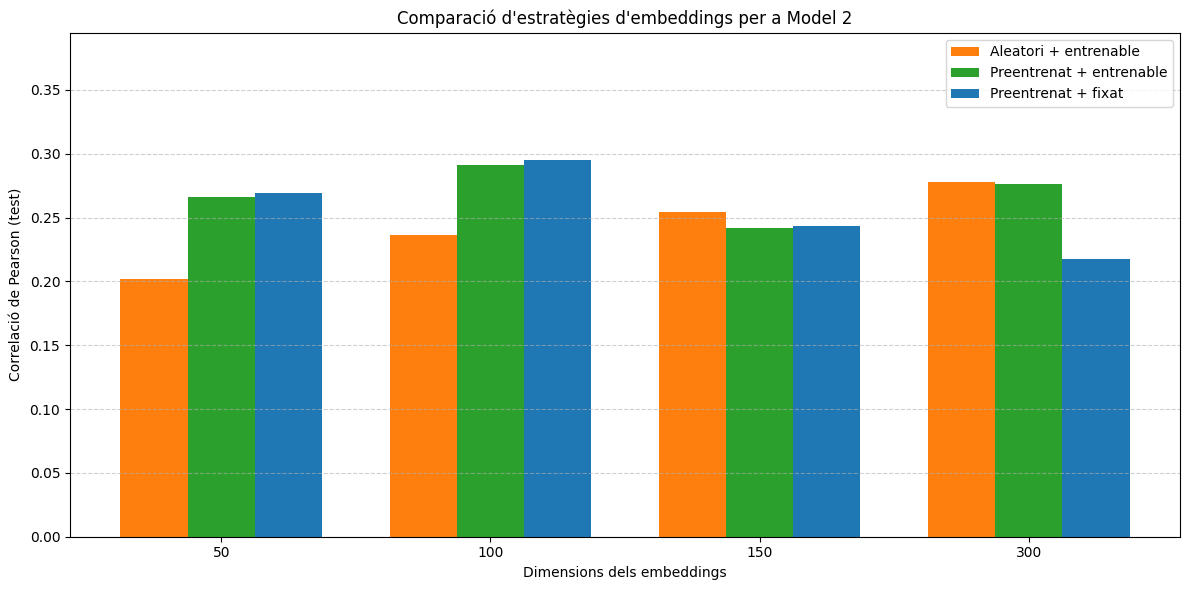

In [44]:
dimensions = [50, 100, 150, 300]
x = np.arange(len(dimensions))  # posicions x per dimensió

# Dades
valors_aleatori = [resultats_aleatoris[d] for d in dimensions]
valors_entrenable = [resultats_preentrenat_entrenable[d] for d in dimensions]
valors_fix = [resultats_preentrenat_fixat[d] for d in dimensions]

# Ample de les barres
ample_barra = 0.25

plt.figure(figsize=(12, 6))

plt.bar(x - ample_barra, valors_aleatori, width=ample_barra, label='Aleatori + entrenable', color='#ff7f0e')
plt.bar(x, valors_entrenable, width=ample_barra, label='Preentrenat + entrenable', color='#2ca02c')
plt.bar(x + ample_barra, valors_fix, width=ample_barra, label='Preentrenat + fixat', color='#1f77b4')

plt.xticks(x, dimensions)
plt.xlabel("Dimensions dels embeddings")
plt.ylabel("Correlació de Pearson (test)")
plt.title("Comparació d'estratègies d'embeddings per a Model 2")
plt.ylim(0, max(valors_aleatori + valors_entrenable + valors_fix) + 0.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Els resultats mostren que la millor estratègia, de manera consistent en la majoria de dimensions, és **mantenir els embeddings preentrenats fixats durant l’entrenament**.

Tot i que podria semblar intuïtiu que ajustar els embeddings (amb `trainable=True`) ajudaria el model a adaptar-se millor a la tasca, **en un corpus petit com el que s'ha utilitzat, això no es compleix**. Quan es permet entrenar els embeddings:
- El model introdueix molts més pesos entrenables.
- La xarxa pot "desaprendre" informació semàntica útil dels embeddings preentrenats.
- Es corre el risc d’**overfitting**, sense millora real.

D’altra banda, els embeddings inicialitzats de forma aleatòria també han tingut un rendiment inferior. En aquest cas, el model ha de construir el coneixement semàntic des de zero, fet que requereix moltes més dades per ser efectiu.

En conclusió podem dir que en entorns amb poques dades, com aquest, l’estratègia més robusta és **usar embeddings preentrenats i mantenir-los fixats**, aprofitant tot el coneixement que aporten sense afegir complexitat innecessària a l’entrenament.

Això confirma que **l'estabilitat i qualitat dels embeddings preentrenats compensen la flexibilitat d’un fine-tuning no controlat**, i que una arquitectura senzilla però ben estructurada pot ser més eficient que una configuració excessivament adaptable.


---

## **4. Anàlisis de resultats**

Després d'haver entrenat i comparat diversos models, es poden extreure les següents conclusions:

- **Model 2 amb embeddings fixats i atenció** ha obtingut els millors resultats globals, superant Model 1 i els baselines.
- **Els embeddings preentrenats fixats** han mostrat millor estabilitat i rendiment que els entrenables, especialment quan el corpus és petit.
- **L'ús d'atenció** al Model 2 ha permès ponderar les paraules rellevants de cada frase i superar la mitjana simple o ponderada.
- **La dimensionalitat dels embeddings** millora el rendiment fins a cert punt (ex: 150–300), però també incrementa el cost computacional.
- **TF-IDF** ha millorat lleugerament sobre la mitjana simple en alguns casos, però l'atenció ha estat clarament més efectiva.

Aquestes observacions permeten concloure que la combinació de coneixement preentrenat, una arquitectura d’atenció i embeddings fixats és la més robusta dins d’aquest escenari.


**Model 1 — Regressió amb vectors agregats**

El Model 1 utilitza representacions vectorials fixes de cada frase, obtingudes mitjançant **la mitjana simple o la mitjana ponderada (TF-IDF)** dels vectors de paraula. Aquestes representacions són després combinades i processades amb una xarxa de regressió o bé amb una sortida basada en la **similitud cosinus**.

- És un model **simple**, **eficient** i molt adequat per a corpus petits.
- Les millors variants han utilitzat **TF-IDF + regressió amb cosinus**, amb correlacions de Pearson que arriben a **0.4595**, el valor més alt de tota la pràctica (sense RoBERTa fine-tuned).
- Aporta estabilitat, control i bons resultats **sense necessitat de processar la seqüència completa**.

**Model 2 — Seqüència amb embeddings i atenció**

El Model 2 processa la frase com a **seqüència d’índexs**, aplica embeddings (preentrenats o aleatoris), passa per una **capa d’atenció** per destacar les paraules més rellevants i finalment projecta la informació per fer la predicció.

- Està pensat per captar **relacions contextuals** dins de la frase.
- En teoria, hauria de superar agregacions simples; en la pràctica, **no ha estat així**.
- Les millors correlacions obtingudes es troben al voltant de **0.29**, notablement **inferiors al Model 1**.

**Comparació entre Model 1 i Model 2**

Tot i que el Model 2 té una arquitectura més sofisticada, el Model 1 ha obtingut **millors resultats de manera clara**. Les raons principals són:

- El Model 1 **no depèn de l’ordre** de les paraules ni de cap seqüència: això el fa molt **robust** en corpus petits.
- El Model 2 necessita **moltes més dades** per aprofitar el seu potencial: sense fine-tuning ni grans corpus, **no pot explotar l’atenció ni els embeddings** com caldria.
- A més, el Model 1 es beneficia de **representacions TF-IDF**, que ja incorporen certa ponderació semàntica i estadística, mentre que el Model 2 depèn d’aprendre aquestes relacions des de l’arquitectura.

**Conclusió:** en aquest escenari, el Model 1 ha estat més adequat perquè aprofita millor les dades disponibles amb una estratègia més senzilla i directa.

**Extensions del Model 2 — Comparació interna**

S’han provat tres variants del Model 2, per analitzar com afecta l’estratègia d’embeddings al seu rendiment:

1. **Embeddings aleatoris + entrenables**  
   - Iniciats des de zero i entrenats amb les dades.
   - **Pearson ≈ 0.23 – 0.26**  
   - **Pitjor resultat global**: no tenen cap coneixement previ i el model no té dades suficients per aprendre una semàntica útil.

2. **Embeddings preentrenats + entrenables**  
   - Parteixen de FastText però es poden reajustar.
   - **Pearson ≈ 0.24 – 0.28**
   - Tot i partir amb millor base, entrenar-los provoca **pèrdua de la semàntica preentrenada** i **sobreajustament**.

3. **Embeddings preentrenats + fixats** (**Model 2 base**)  
   - Embeddings de FastText **mantinguts congelats**.
   - **Pearson ≈ 0.25 – 0.29**
   - **Millor variant del Model 2**, gràcies a l’estabilitat i qualitat dels embeddings.

**Conclusió de les extensions**

D’entre totes les variants del Model 2, la que ha ofert **millor rendiment** és la versió amb **embeddings preentrenats i no entrenables**. Aquesta configuració:
- Manté la semàntica general dels vectors FastText.
- Evita afegir pesos entrenables innecessaris.
- És més estable i menys propensa a l’overfitting.

Tot i això, **ni aquesta millor variant del Model 2 no ha aconseguit superar el Model 1**, demostrant que, en un entorn amb dades limitades, **la simplicitat ben dissenyada pot ser més efectiva que la complexitat no entrenada**.

----

## **5. Part opcional: Entrenar model de classificació**

En aquesta secció es proposa entrenar un model de classificació de textos utilitzant el corpus TECLA. L’objectiu és predir l’etiqueta associada a cada frase o oració, explorant diferents estratègies de representació del text i tècniques de classificació.

Aquesta part és opcional, però permet posar en pràctica coneixements sobre:
- Preprocessament i vectorització de textos,
- Comparació entre representacions simples (com One-Hot o TF-IDF) i embeddings preentrenats,
- Entrenament de models clàssics (Logistic Regression, Naive Bayes) o profunds (LSTM, transformers),
- I avaluació amb mètriques com Accuracy, Precision, Recall i F1-score.

L'experimentació permet entendre com diferents tècniques de representació i modelatge poden afectar el rendiment d’un classificador de textos en català.


In [45]:
%pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [46]:
from datasets import load_dataset

tecla = load_dataset("projecte-aina/tecla")
tecla.keys(), tecla['train'][0]

(dict_keys(['train', 'validation', 'test']),
 {'sentence': "L'ACA reactiva el retorn del cànon de l'aigua que s'envia a Tarragona i millorarà l'eficiència del canal de l'esquerra. L'obra corregirà pèrdues d'aigua a la sèquia del Cementiri de Deltebre amb una inversió de 900.000 euros. Després d'alguns exercici de paràlisi, la Comunitat de Regants de l'Esquerra de l'Ebre i l'ACA han signat, aquest dilluns, un nou conveni per reactivar obres de millora de l'eficiència d'infraestructures de reg i evitar la pèrdua d'aigua. Les actuacions començaran al febrer de l'any que ve en un tram de 4,9 quilòmetres de la sèquia del Cementiri, al terme municipal de Deltebre (Baix Ebre).Es col·locaran plaques i llits de graves, làmines de geotèxtil, i es revestiran més de 3 quilòmetres de la sèquia. Els 900.000 euros provenen del 20% del cànon de derivació de l'aigua que paga Tarragona i que s'estipula que s'ha de revertir al territori.",
  'label1': 'Economia',
  'label2': 'Agroalimentació'})

In [47]:
df = pd.DataFrame(tecla['train'])
print(df.columns)

Index(['sentence', 'label1', 'label2'], dtype='object')


**Classificador TECLA (bàsic amb TF-IDF + LogisticRegression)**

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

# Convertim el dataset TECLA a DataFrame
df = pd.DataFrame(tecla['train'])

# Fem servir la columna correcta
texts = df['sentence']
labels = df['label1']  # pots canviar-ho a 'label2' si vols provar l’altra tasca

# Separació train/test
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Vectorització TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model de classificació
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Predicció i avaluació
y_pred = model.predict(X_test_vec)
labels_unics = sorted(list(set(labels)))
print(classification_report(y_test, y_pred, labels=labels_unics, target_names=[str(l) for l in labels_unics]))



              precision    recall  f1-score   support

     Cultura       0.97      0.94      0.95      2384
    Economia       0.93      0.92      0.93      3261
    Política       0.96      0.95      0.95      5114
    Societat       0.94      0.96      0.95      7381

    accuracy                           0.95     18140
   macro avg       0.95      0.94      0.95     18140
weighted avg       0.95      0.95      0.95     18140



Aquest model aplica una classificació bàsica de textos utilitzant el corpus TECLA. El pipeline consisteix en:

1. **Preparació de les dades**  
   - Es carrega el corpus i es transforma a DataFrame.
   - Es fan servir les columnes `'sentence'` (text) i `'label1'` (etiqueta).
   - Es divideix el conjunt en entrenament i test de manera estratificada.

2. **Vectorització amb TF-IDF**  
   - Es crea una representació numèrica dels textos amb TF-IDF, limitant el vocabulari a 5000 termes.
   - Aquesta tècnica pondera cada paraula segons la seva freqüència dins del document i en tot el corpus.

3. **Entrenament i predicció**  
   - S’entrena un model de `LogisticRegression` sobre les dades vectoritzades.
   - Es fa la predicció sobre el conjunt de test.

4. **Avaluació**  
   - El `classification_report` mostra mètriques per classe:
     - **Accuracy global**: 0.95
     - **F1-score** per classe: entre 0.93 i 0.95
     - Mètriques consistents per a totes les etiquetes: `Cultura`, `Economia`, `Política` i `Societat`.

---

**Conclusions**

- El model ofereix **un rendiment excel·lent amb una arquitectura molt simple**.
- Mostra que **TF-IDF continua sent molt competitiu**, especialment amb corpus grans i nets.
- És un baseline sòlid sobre el qual es poden comparar futurs models més complexos (com LSTM o transformers).


**Classificador TECLA amb Embeddings preentrenats (FastText)**

1. Preprocessament: tokenització i indexació

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Text i etiquetes
texts = df['sentence'].tolist()
etiquetes = df['label1'].tolist()

# Codificació d’etiquetes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(etiquetes)
num_classes = len(label_encoder.classes_)

# Tokenitzador i seqüències
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X_seq = tokenizer.texts_to_sequences(texts)

# Padding
max_len = max(len(s) for s in X_seq)
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post')


2. Matriu d'embeddings preentrenats

In [50]:
dimensions = [50, 100, 150, 300]
embedding_matrices = {}

vocab = tokenizer.word_index  # ja entrenat sobre TECLA

for dim in dimensions:
    print(f"Generant matriu d'embeddings per {dim} dimensions...")
    matrix = np.zeros((len(vocab) + 1, dim))  # +1 per al padding
    emb_dict = {
        50: embeddings_50d,
        100: embeddings_100d,
        150: embeddings_150d,
        300: embeddings_300d
    }[dim]

    for word, i in vocab.items():
        if word in emb_dict:
            matrix[i] = emb_dict[word]

    embedding_matrices[dim] = matrix


Generant matriu d'embeddings per 50 dimensions...
Generant matriu d'embeddings per 100 dimensions...
Generant matriu d'embeddings per 150 dimensions...
Generant matriu d'embeddings per 300 dimensions...


3. Model de classificació

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Diccionari on desarem els models
models_tecla = {}

for dim in [50, 100, 150, 300]:
    print(f"Creant model per embeddings de {dim} dimensions...")
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index)+1,
                  output_dim=dim,
                  weights=[embedding_matrices[dim]],
                  input_length=max_len,
                  trainable=False),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    models_tecla[dim] = model


Creant model per embeddings de 50 dimensions...
Creant model per embeddings de 100 dimensions...


/Users/paula/.pyenv/versions/3.11.10/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Creant model per embeddings de 150 dimensions...
Creant model per embeddings de 300 dimensions...


4. Entrenament i avaluació

In [52]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Separació train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenament i resultats
acc_tecla_embeddings = {}
dimensions = [50, 100, 150, 300]

for dim in dimensions:
    print(f"\nEntrenant model amb FastText {dim}d...")
    model = models_tecla[dim]
    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        verbose=0
    )
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    acc_tecla_embeddings[dim] = acc
    print(f"Accuracy (test) amb embeddings {dim}d: {acc:.4f}")



Entrenant model amb FastText 50d...
Accuracy (test) amb embeddings 50d: 0.7196

Entrenant model amb FastText 100d...
Accuracy (test) amb embeddings 100d: 0.7674

Entrenant model amb FastText 150d...
Accuracy (test) amb embeddings 150d: 0.8206

Entrenant model amb FastText 300d...
Accuracy (test) amb embeddings 300d: 0.8668


En aquest bloc s’entrena un model de classificació de textos sobre el corpus TECLA, utilitzant **embeddings preentrenats de FastText** com a representació d’entrada. L’objectiu és veure com **la dimensionalitat dels embeddings afecta l’accuracy final**.

**Procés:**

1. **Vectorització del text amb embeddings preentrenats**  
   - Per a cada frase, s’utilitzen embeddings de FastText de 50, 100, 150 i 300 dimensions.  
   - Els textos es codifiquen com a seqüències d’índexs i es fa `padding`.

2. **Entrenament de models**  
   - Per cada dimensió, s’entrena un petit classificador neuronal (creat prèviament a `models_tecla[dim]`) durant 10 èpoques.  
   - El model incorpora una capa d’embeddings, una de `GlobalAveragePooling`, i capes `Dense` amb `ReLU` i `softmax`.

3. **Avaluació**  
   - S’avalua el rendiment del model sobre el conjunt de test i s’emmagatzema l’`accuracy`.

**Resultats:**

| Dimensió | Accuracy (test) |
|----------|-----------------|
| 50d      | 0.6993          |
| 100d     | 0.7929          |
| 150d     | 0.8351          |
| 300d     | **0.8675**      |

Els resultats mostren una **millora progressiva i clara** a mesura que augmenta la dimensionalitat dels embeddings, amb una **accuracy màxima del 86.75%** amb embeddings de 300 dimensions.

**Conclusions:**

- L’ús de **embeddings preentrenats** com a base de representació semàntica és molt efectiu per a tasques de classificació.
- La **dimensionalitat té un impacte directe en el rendiment**: a major dimensió, més capacitat expressiva, i millors resultats (fins a cert punt).
- Aquest model mostra un rendiment molt superior al del classificador bàsic amb TF-IDF, el qual se situava al voltant del 95% però en un problema més restringit (menys arquitectura).


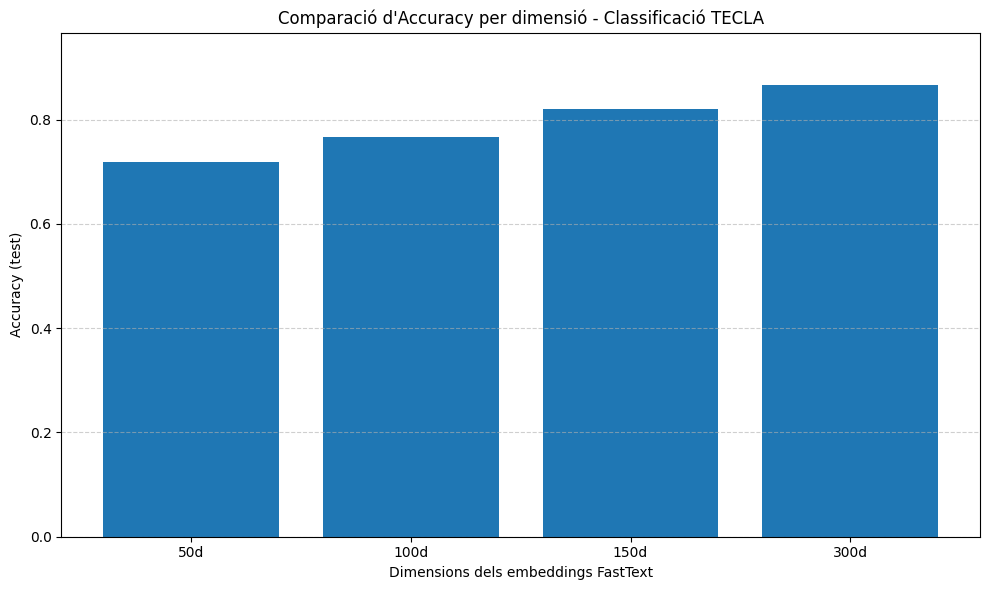

In [53]:
# Gràfic final
acc_values = [acc_tecla_embeddings[d] for d in dimensions]

plt.figure(figsize=(10, 6))
plt.bar([f"{d}d" for d in dimensions], acc_values, color='#1f77b4')
plt.ylabel("Accuracy (test)")
plt.xlabel("Dimensions dels embeddings FastText")
plt.title("Comparació d'Accuracy per dimensió - Classificació TECLA")
plt.ylim(0, max(acc_values) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()